In [1]:
!pip install ecg-plot
import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
from keras.models import Sequential, Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers.merge import concatenate
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
gender, age, labels, ecg_filenames = pc.import_key_data("/kaggle/input/")
ecg_filenames = np.asarray(ecg_filenames)

In [3]:
SNOMED_scored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [4]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


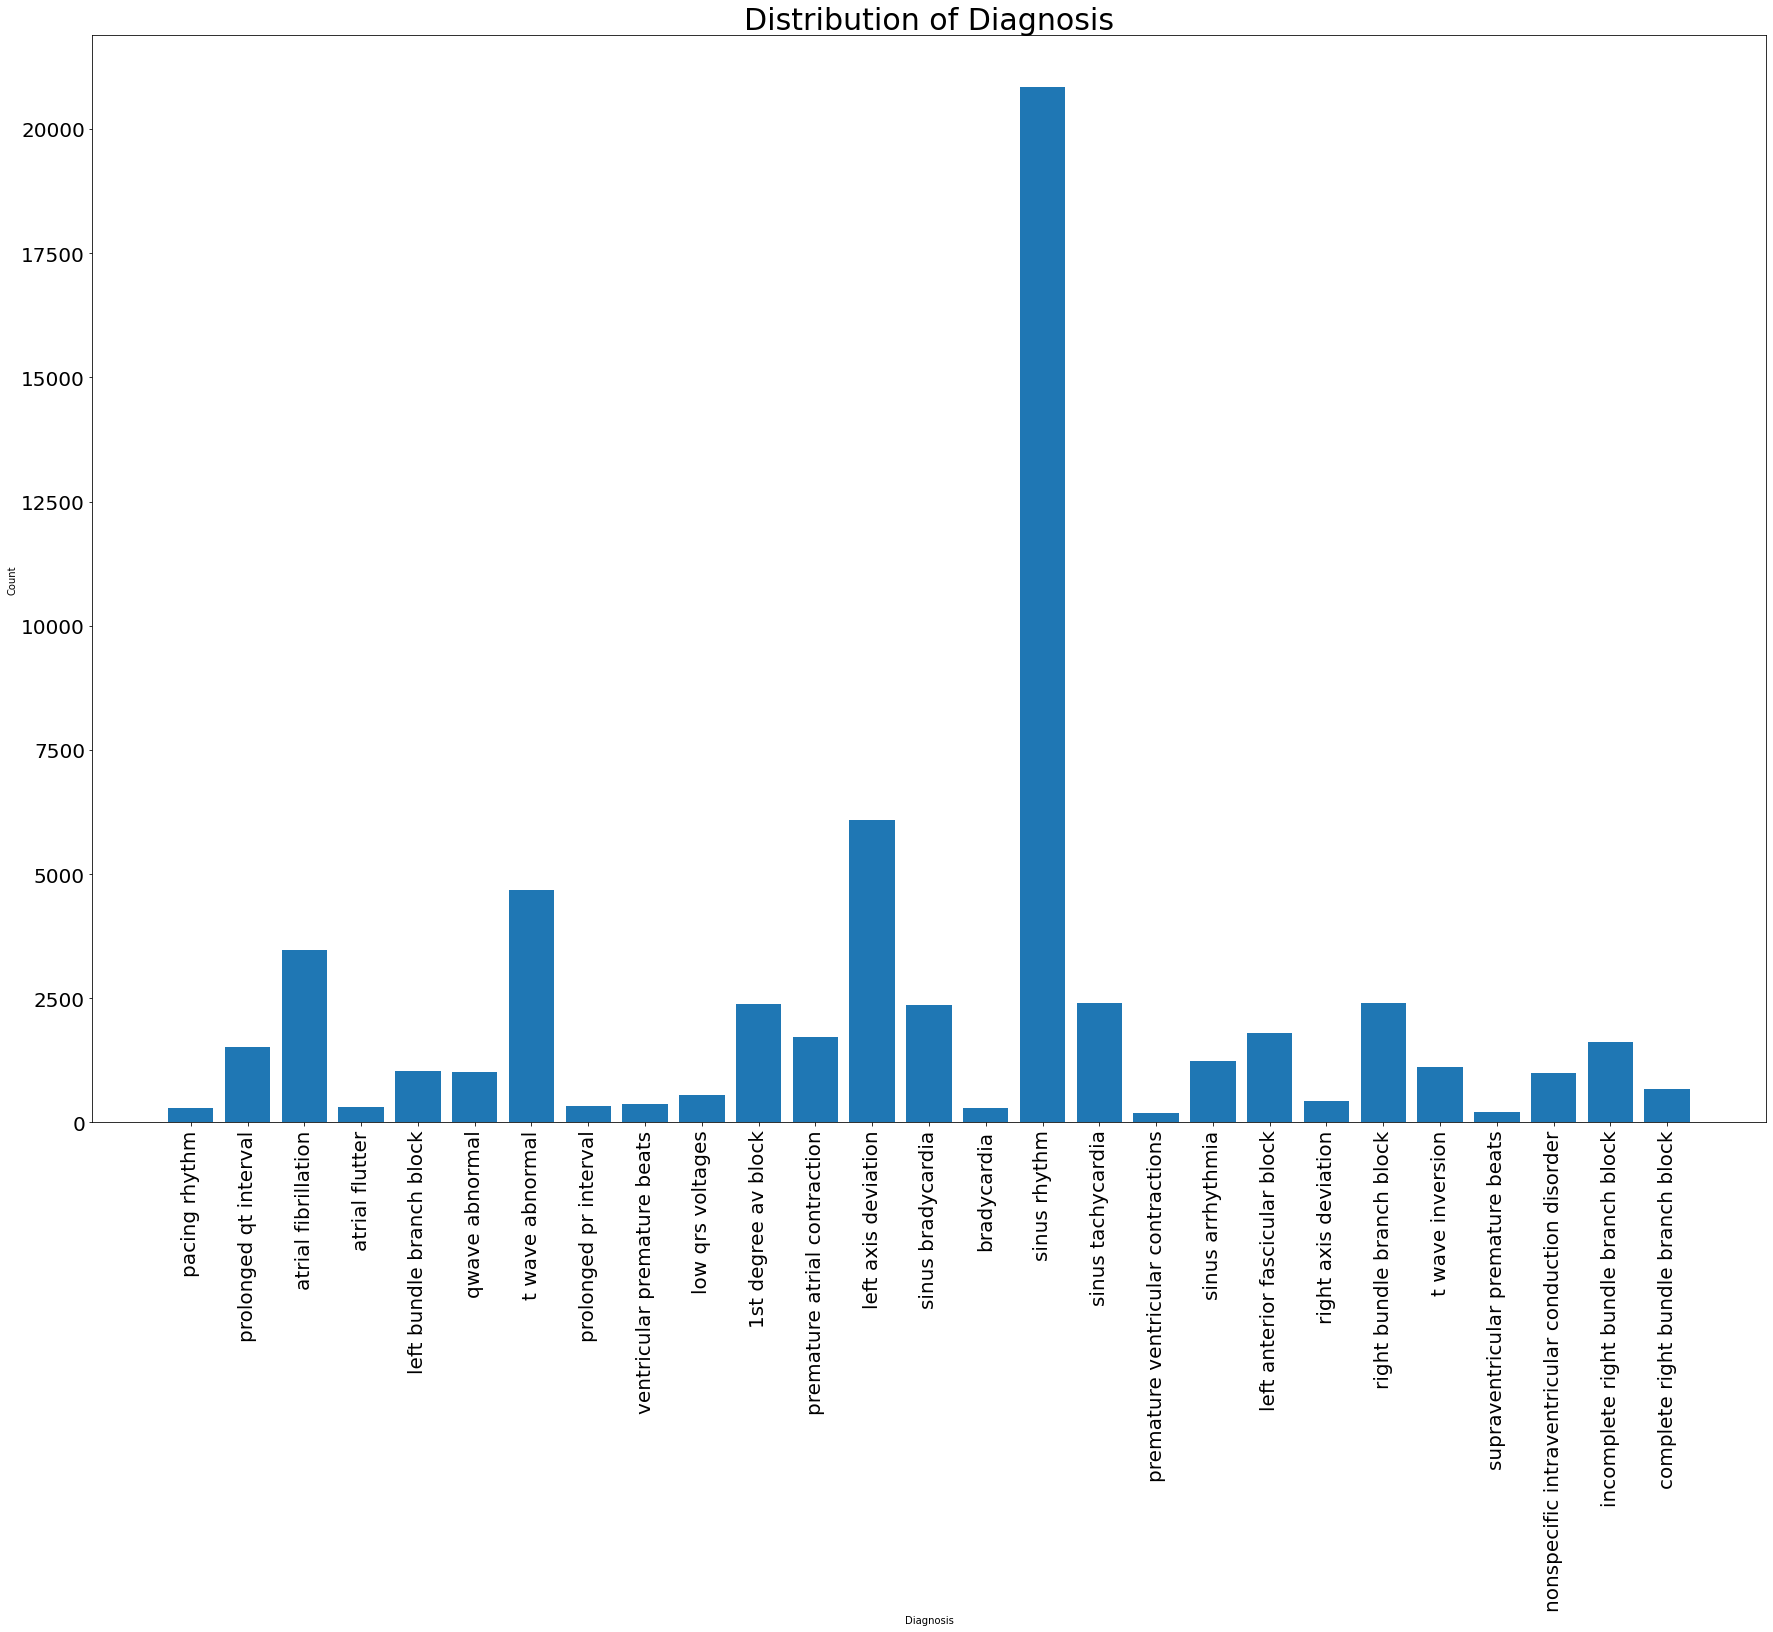

In [5]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

In [6]:
y_all_comb = pc.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 1414


In [7]:
folds = pc.split_data(labels, y_all_comb)

Training split: 38790
Validation split: 4311


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


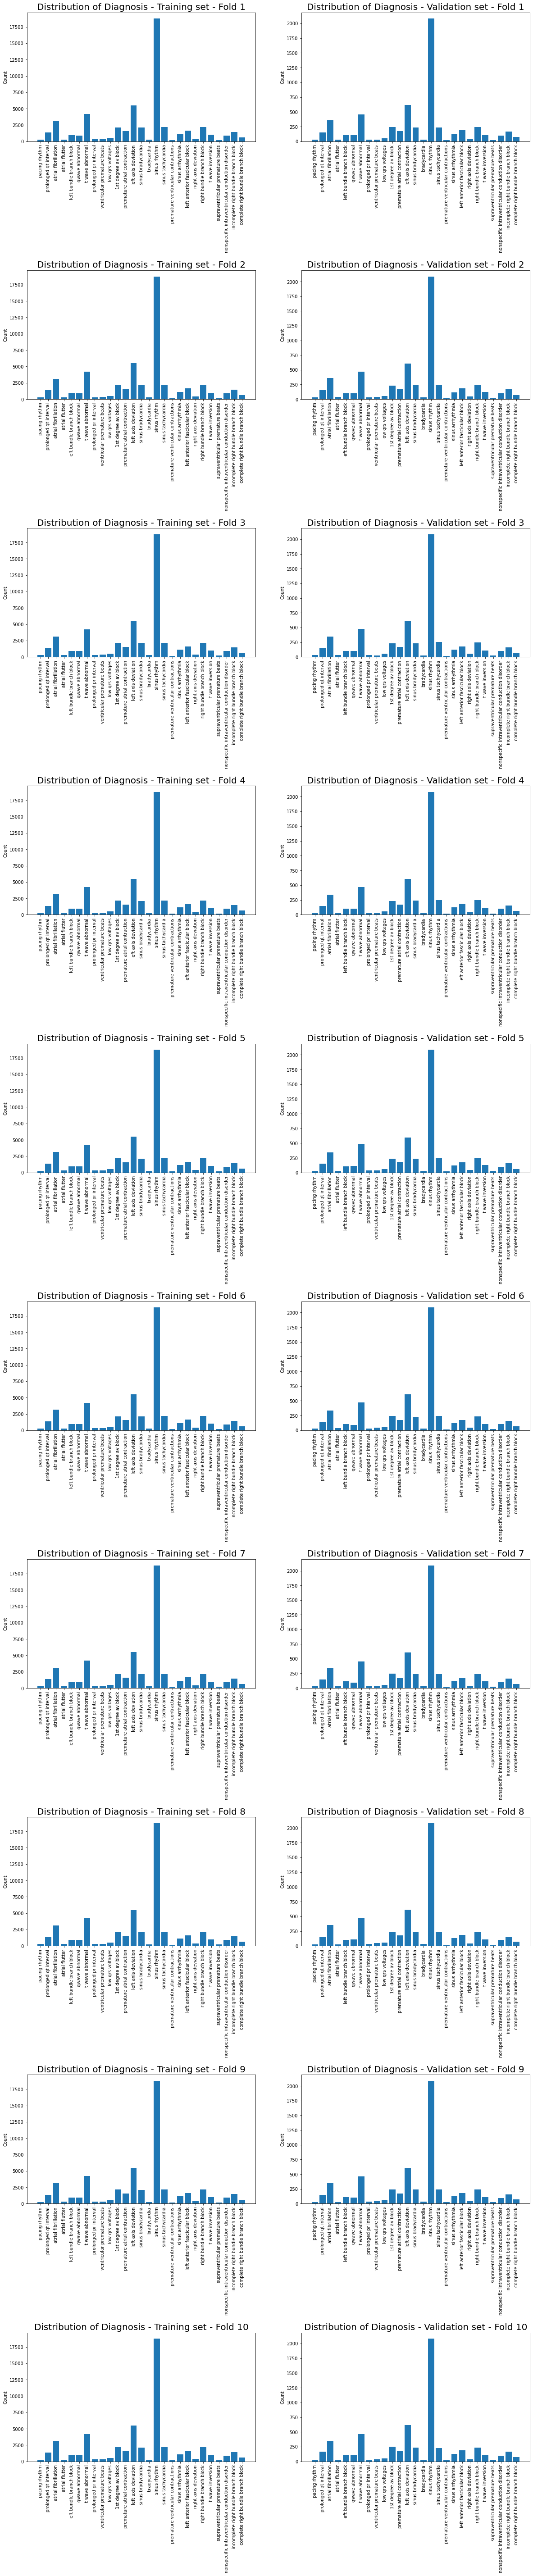

In [8]:
pc.plot_all_folds(folds,y,snomed_classes)

In [9]:
order_array = folds[0][0]

In [10]:
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [12]:
def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

In [13]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [14]:
def generate_validation_data(ecg_filenames, y,test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_train_gridsearch = np.asarray(ecg_train_timeseries)

    X_train_gridsearch = X_train_gridsearch.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)

    return X_train_gridsearch, y_train_gridsearch

In [15]:
def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A

In [16]:
def plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, val_fold, threshold, snomedclasses):
    df_cm = pd.DataFrame(compute_modified_confusion_matrix(generate_validation_data(ecg_filenames,y,val_fold)[1], (y_pred>threshold)*1), columns=snomedclasses, index = snomedclasses)
    df_cm = df_cm.fillna(0)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    df_norm_col=(df_cm-df_cm.mean())/df_cm.std()
    plt.figure(figsize = (36,14))
    sns.set(font_scale=1.4)
    sns.heatmap(df_norm_col, cmap="Blues", annot=True,annot_kws={"size": 16},fmt=".2f",cbar=False)# font size

# Results

# Simple ANN

In [17]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(5000,12)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(27, activation='sigmoid'))

In [18]:
 ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [19]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5000, 50)          650       
_________________________________________________________________
dense_1 (Dense)              (None, 5000, 50)          2550      
_________________________________________________________________
dense_2 (Dense)              (None, 5000, 50)          2550      
_________________________________________________________________
dense_3 (Dense)              (None, 5000, 50)          2550      
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                1377      
Total params: 9,677
Trainable params: 9,677
Non-trainable params: 0
______________________________________________________

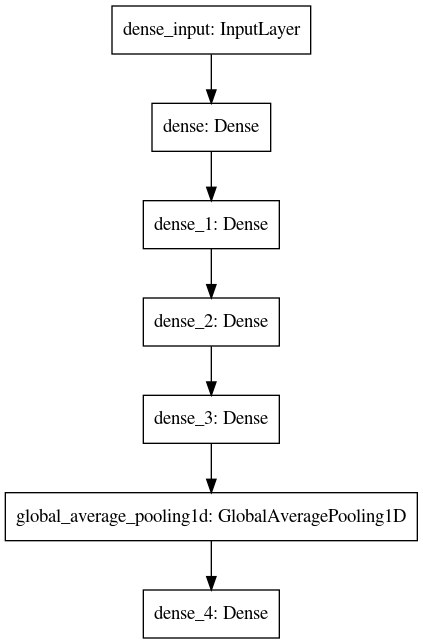

In [20]:
plot_model(ann_model)

In [21]:
batchsize = 10
ann_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), callbacks=[reduce_lr,early_stop])

Epoch 1/10
388/387 [==============================] - 15s 38ms/step - loss: 0.3360 - accuracy: 0.9344 - Recall: 0.1619 - Precision: 0.2725 - AUC: 0.4780 - val_loss: 0.2031 - val_accuracy: 0.9474 - val_Recall: 0.0061 - val_Precision: 0.2450 - val_AUC: 0.5237 - lr: 0.0010
Epoch 2/10
388/387 [==============================] - 15s 38ms/step - loss: 0.1923 - accuracy: 0.9481 - Recall: 0.1551 - Precision: 0.4846 - AUC: 0.5107 - val_loss: 0.1754 - val_accuracy: 0.9524 - val_Recall: 0.2727 - val_Precision: 0.5911 - val_AUC: 0.5446 - lr: 0.0010
Epoch 3/10
388/387 [==============================] - 17s 44ms/step - loss: 0.1770 - accuracy: 0.9493 - Recall: 0.1510 - Precision: 0.5278 - AUC: 0.5241 - val_loss: 0.1685 - val_accuracy: 0.9484 - val_Recall: 0.0313 - val_Precision: 0.5575 - val_AUC: 0.5603 - lr: 0.0010
Epoch 4/10
388/387 [==============================] - 17s 45ms/step - loss: 0.1662 - accuracy: 0.9494 - Recall: 0.1586 - Precision: 0.5461 - AUC: 0.5585 - val_loss: 0.1662 - val_accuracy:

Text(0, 0.5, 'Accuracy')

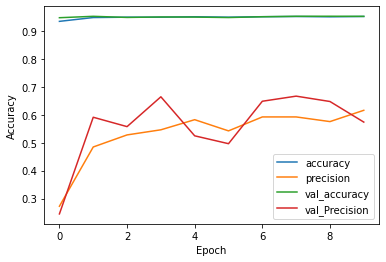

In [22]:
plt.plot(ann_model.history.history['accuracy'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['val_accuracy'])
plt.plot(ann_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

"Accuracy" and "Precision" are overlapping in the graph above.

Text(0, 0.5, 'Loss')

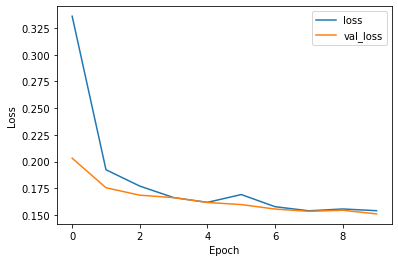

In [23]:
plt.plot(ann_model.history.history['loss'])
plt.plot(ann_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

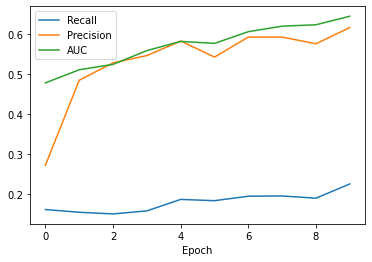

In [24]:
plt.plot(ann_model.history.history['Recall'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [25]:
y_pred = ann_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [26]:
init_thresholds = np.arange(0,1,0.05)

In [27]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.18701429366138062
0.19867623294335912
0.15101945290648
0.09186503012491022
0.05180065079164211
0.027796775419818946
0.007494220295761405
-0.012758926114560072
-0.05041752047626925
-0.10560182589884089
-0.21640151121656653
-0.4058883662333227
-0.6578361766907626
-0.7820716747221163
-0.8164138093741863
-0.82250480128856
-0.8229390589230428
-0.8232171789810823
-0.8236855917104119


In [28]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.202551
         Iterations: 24
         Function evaluations: 254


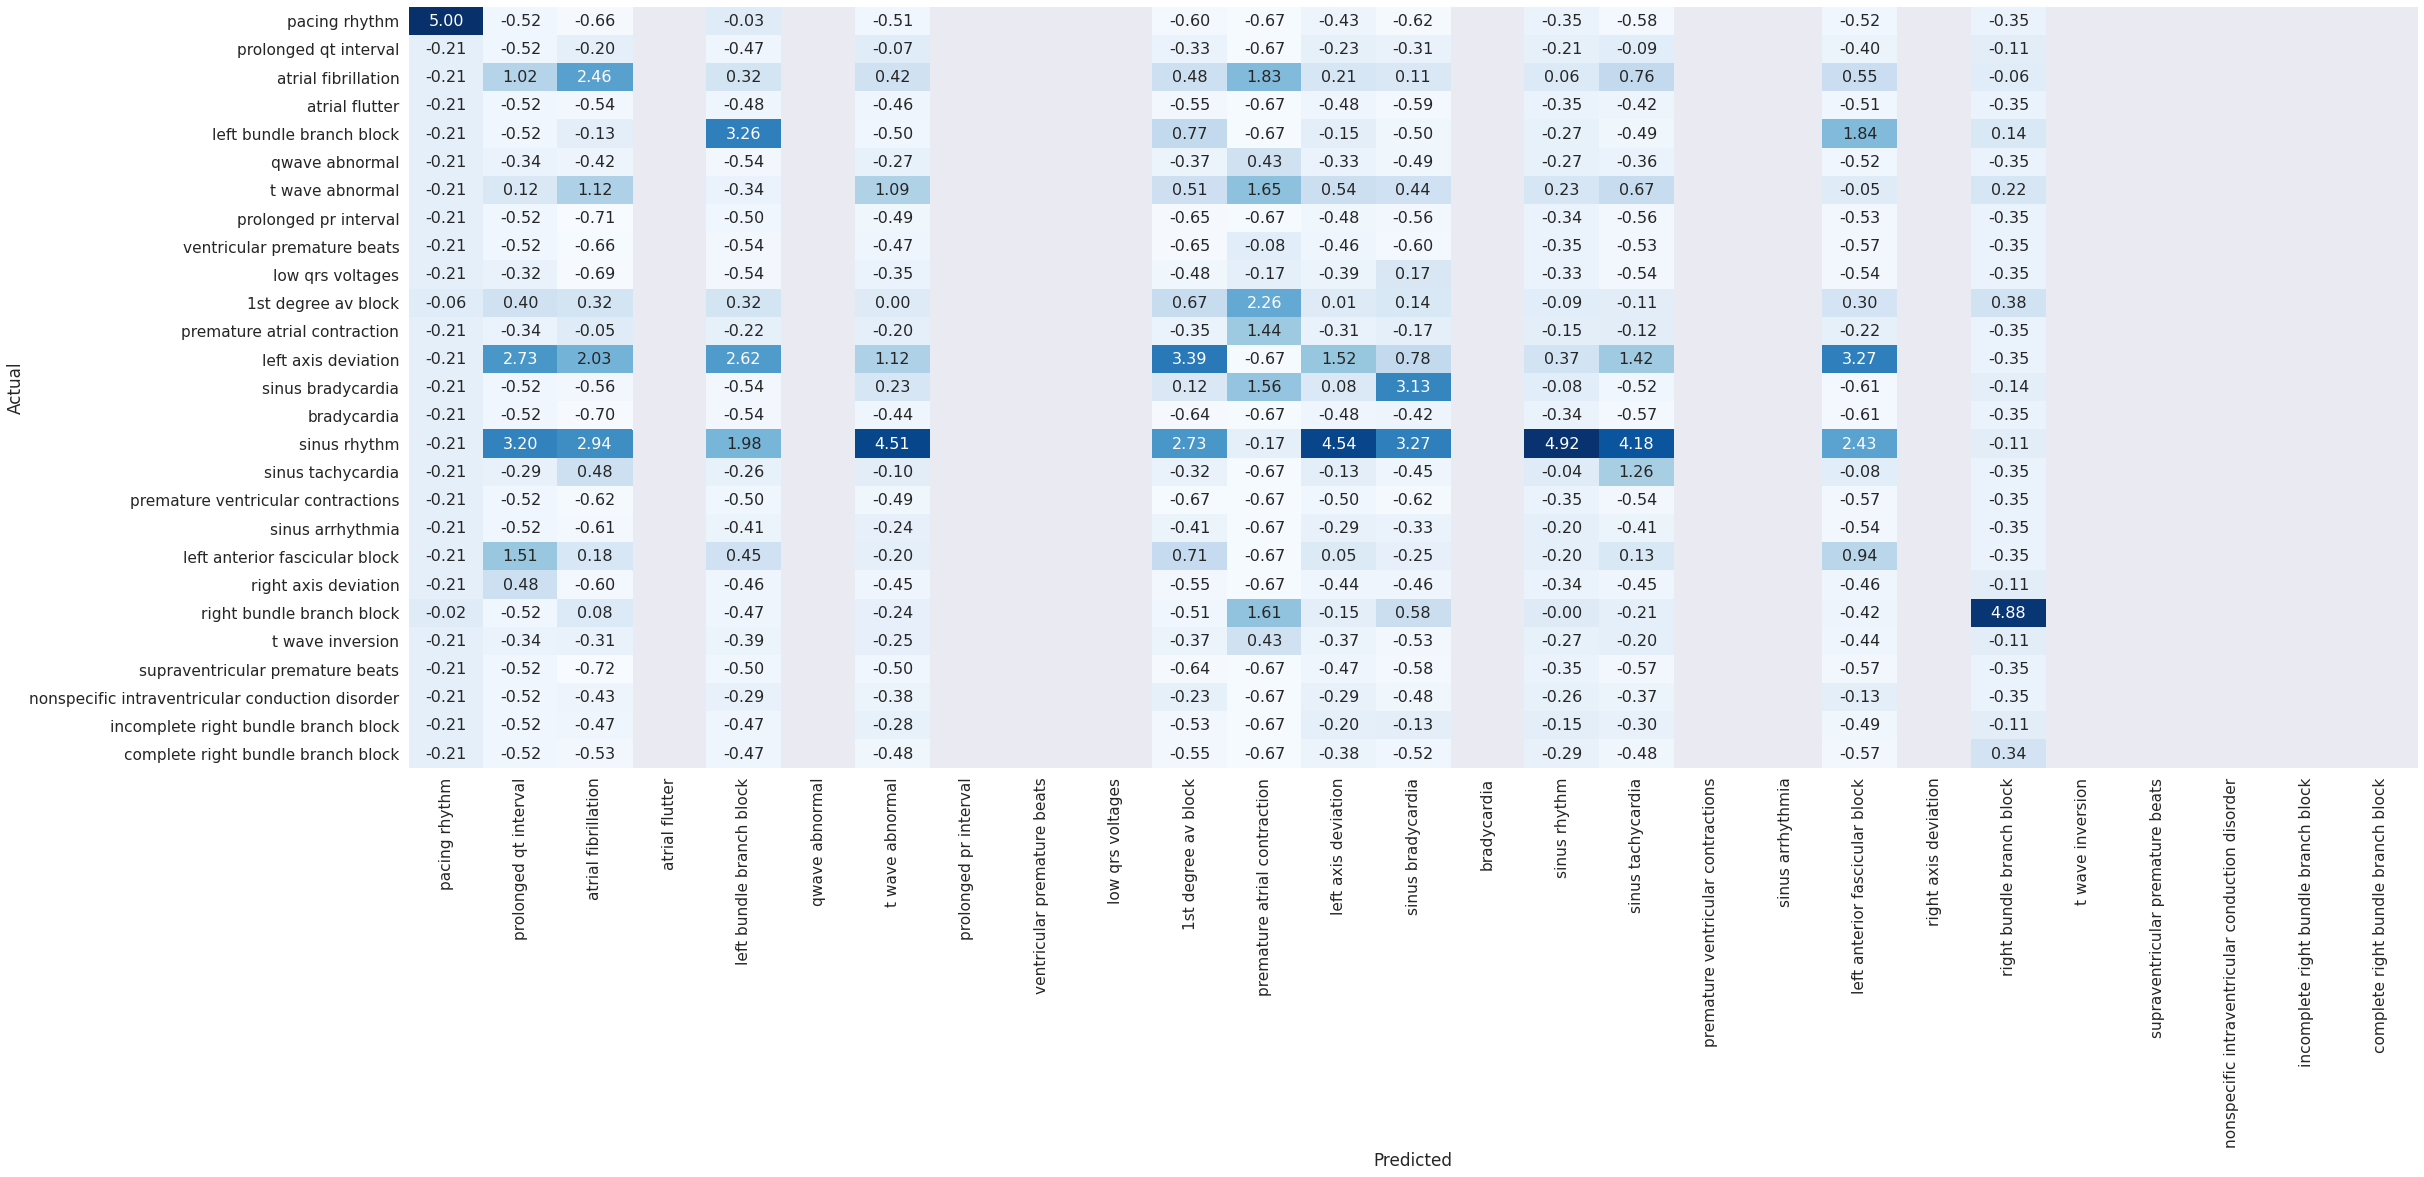

In [29]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_ann.png", dpi=100)

# CNN

# Lenet-5

In [30]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(5000,12)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv1D(filters=16, strides=1, kernel_size=5))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(GlobalAveragePooling1D())

lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(27, activation = 'sigmoid'))

In [31]:
 lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [32]:
lenet_5_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5000, 6)           222       
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 6)           24        
_________________________________________________________________
activation (Activation)      (None, 5000, 6)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2500, 6)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2496, 16)          496       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2496, 16)          64        
_________________________________________________________________
activation_1 (Activation)    (None, 2496, 16)         

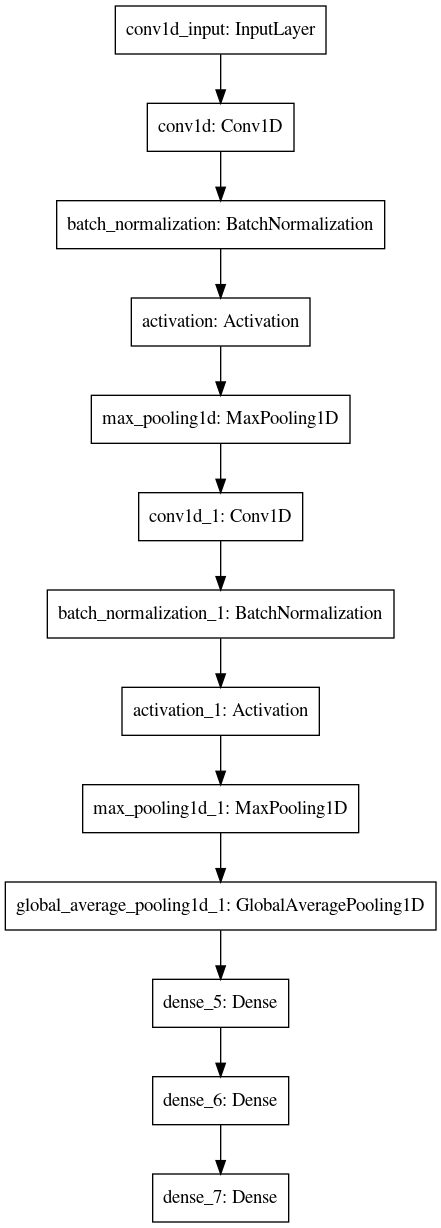

In [33]:
plot_model(lenet_5_model)

In [34]:
batchsize = 10
lenet_5_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), callbacks=[reduce_lr,early_stop])

Epoch 1/10
388/387 [==============================] - 18s 47ms/step - loss: 0.2287 - accuracy: 0.9183 - Recall: 0.1770 - Precision: 0.1883 - AUC: 0.5195 - val_loss: 0.1571 - val_accuracy: 0.9498 - val_Recall: 0.2922 - val_Precision: 0.5300 - val_AUC: 0.6236 - lr: 0.0010
Epoch 2/10
388/387 [==============================] - 18s 47ms/step - loss: 0.1571 - accuracy: 0.9495 - Recall: 0.2031 - Precision: 0.5420 - AUC: 0.5925 - val_loss: 0.1547 - val_accuracy: 0.9504 - val_Recall: 0.2743 - val_Precision: 0.5438 - val_AUC: 0.6419 - lr: 0.0010
Epoch 3/10
388/387 [==============================] - 18s 45ms/step - loss: 0.1556 - accuracy: 0.9495 - Recall: 0.2294 - Precision: 0.5407 - AUC: 0.6105 - val_loss: 0.1524 - val_accuracy: 0.9491 - val_Recall: 0.1191 - val_Precision: 0.5459 - val_AUC: 0.6660 - lr: 0.0010
Epoch 4/10
388/387 [==============================] - 18s 47ms/step - loss: 0.1532 - accuracy: 0.9500 - Recall: 0.1985 - Precision: 0.5382 - AUC: 0.6258 - val_loss: 0.1514 - val_accuracy:

Text(0, 0.5, 'Accuracy')

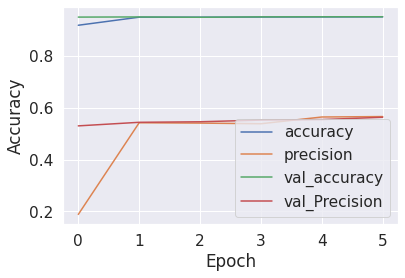

In [35]:
plt.plot(lenet_5_model.history.history['accuracy'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['val_accuracy'])
plt.plot(lenet_5_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

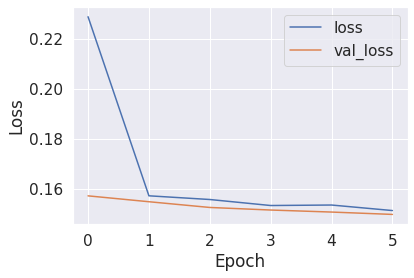

In [36]:
plt.plot(lenet_5_model.history.history['loss'])
plt.plot(lenet_5_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

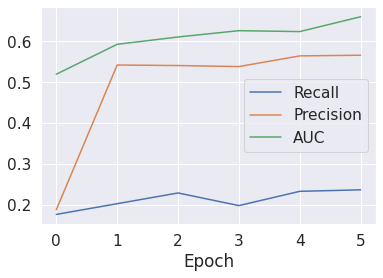

In [37]:
plt.plot(lenet_5_model.history.history['Recall'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [38]:
y_pred = lenet_5_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [39]:
init_thresholds = np.arange(0,1,0.05)

In [40]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.18765300478300284
0.1455813453816643
0.15538637540564956
0.07302338366996604
0.031215642327103294
0.0023054689021698685
-0.021961156735011228
-0.056204683072434564
-0.10606664885799773
-0.21450102415329633
-0.40630782332670506
-0.8067863013533735
-0.8170061563048178
-0.8193186188692654
-0.8220266299607026
-0.8229122227770916
-0.8234131641681803
-0.8238661257831744
-0.8238661257831744


In [41]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.211455
         Iterations: 582
         Function evaluations: 865


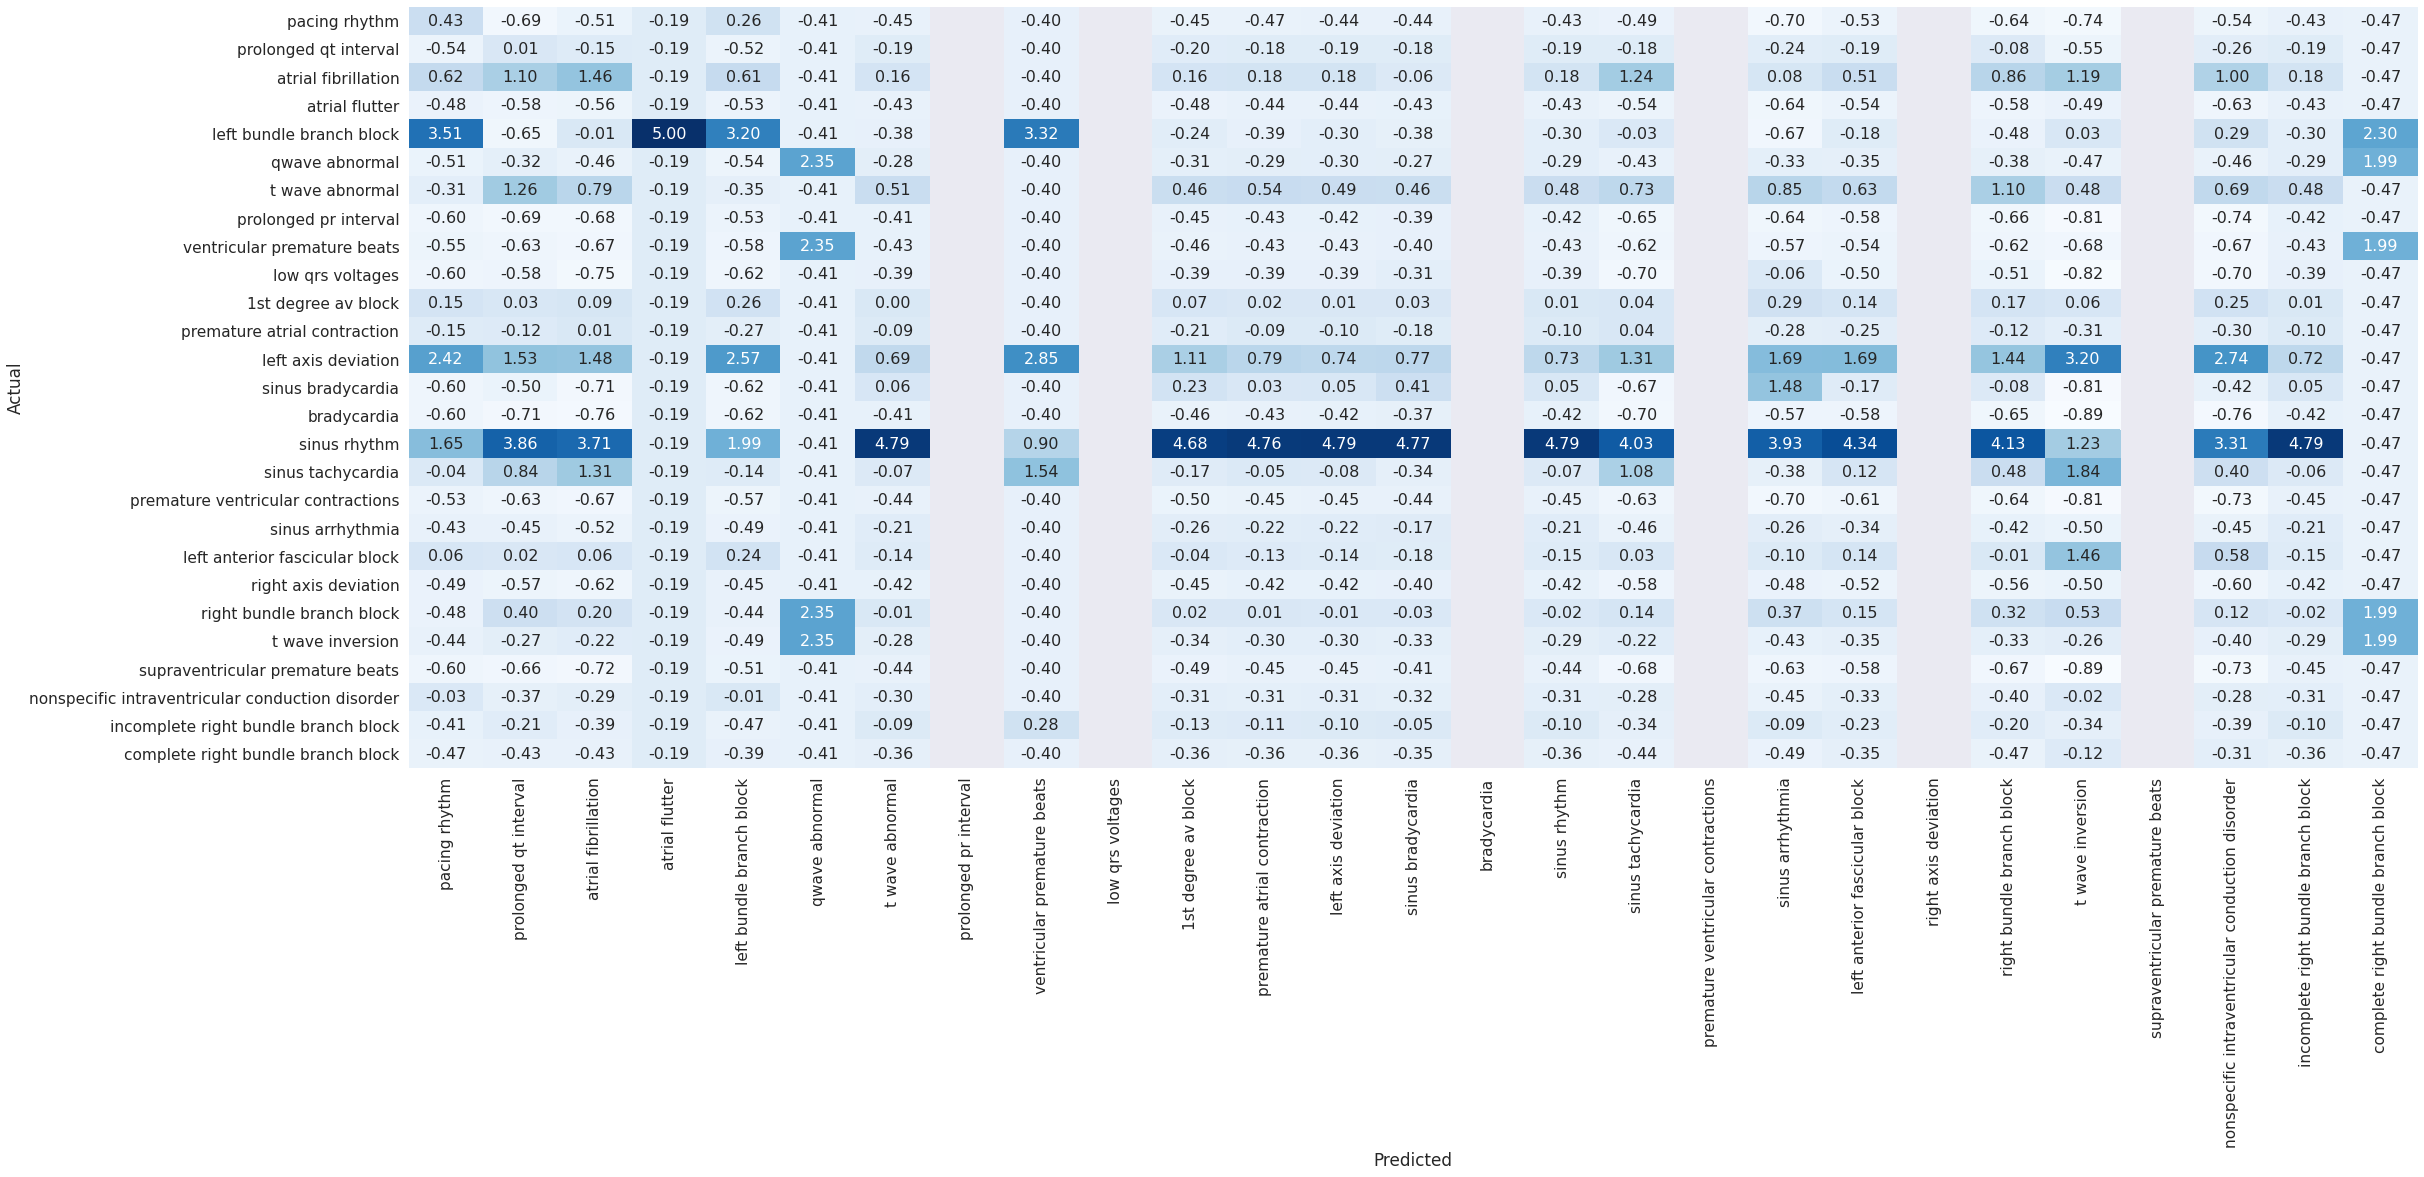

In [42]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_lenet5.png", dpi=100)

# AlexNet

In [43]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(5000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(27, activation='sigmoid'))

In [44]:
 alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [45]:
alexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1248, 96)          12768     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1248, 96)          384       
_________________________________________________________________
activation_2 (Activation)    (None, 1248, 96)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 624, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 624, 256)          123136    
_________________________________________________________________
batch_normalization_3 (Batch (None, 624, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 624, 256)         

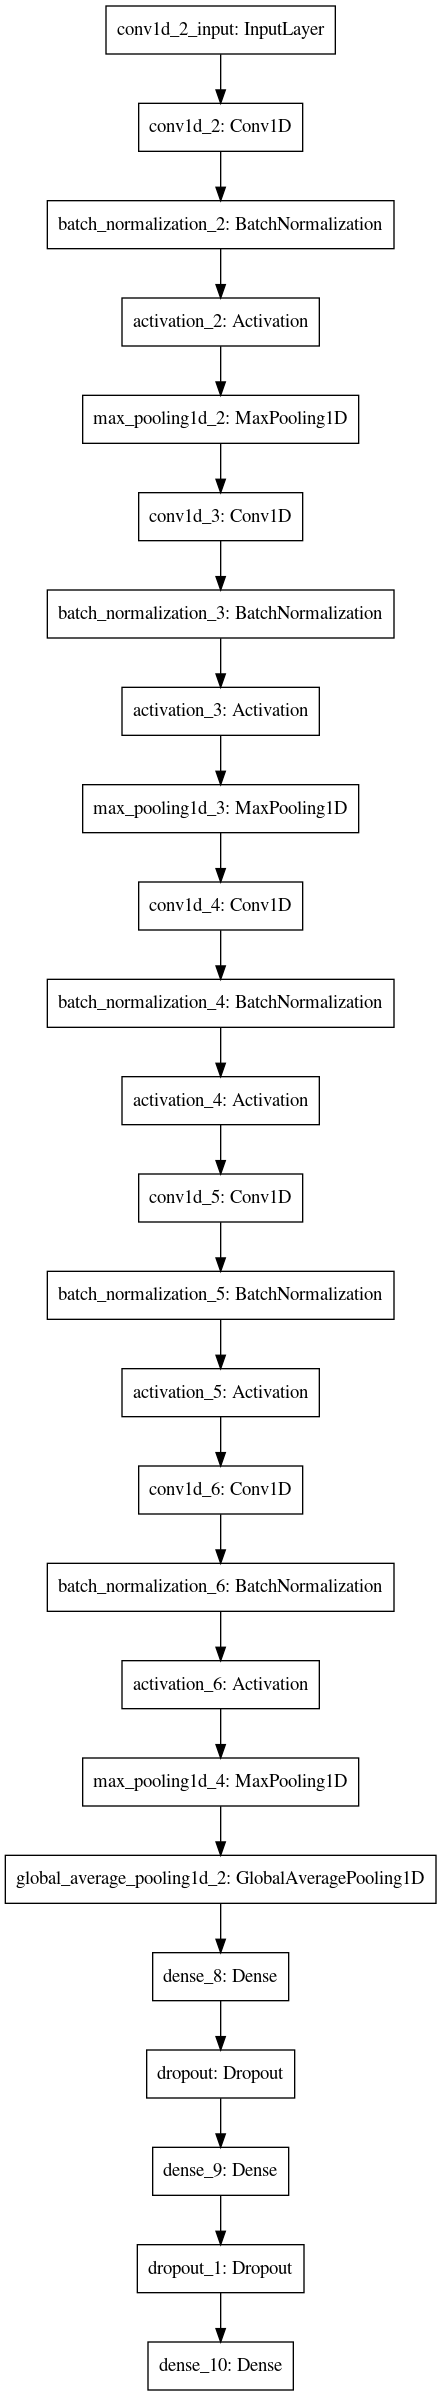

In [46]:
plot_model(alexNet_model)

In [47]:
batchsize = 10
alexNet_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), callbacks=[reduce_lr,early_stop])

Epoch 1/10
388/387 [==============================] - 17s 44ms/step - loss: 0.1895 - accuracy: 0.9445 - Recall: 0.2104 - Precision: 0.4322 - AUC: 0.5674 - val_loss: 0.1494 - val_accuracy: 0.9550 - val_Recall: 0.2181 - val_Precision: 0.7214 - val_AUC: 0.6468 - lr: 0.0010
Epoch 2/10
388/387 [==============================] - 17s 44ms/step - loss: 0.1597 - accuracy: 0.9543 - Recall: 0.2244 - Precision: 0.6435 - AUC: 0.6014 - val_loss: 0.1482 - val_accuracy: 0.9540 - val_Recall: 0.1823 - val_Precision: 0.7274 - val_AUC: 0.6968 - lr: 0.0010
Epoch 3/10
388/387 [==============================] - 17s 45ms/step - loss: 0.1518 - accuracy: 0.9549 - Recall: 0.2513 - Precision: 0.6637 - AUC: 0.6427 - val_loss: 0.1399 - val_accuracy: 0.9569 - val_Recall: 0.2669 - val_Precision: 0.7325 - val_AUC: 0.7391 - lr: 0.0010
Epoch 4/10
387/387 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9556 - Recall: 0.2576 - Precision: 0.6788 - AUC: 0.6734
Epoch 00004: ReduceLROnPlateau reducing 

Text(0, 0.5, 'Accuracy')

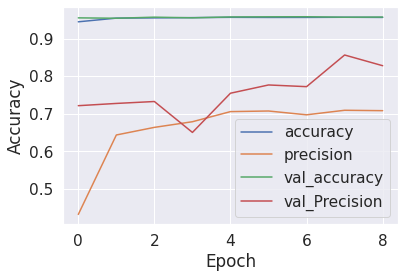

In [48]:
plt.plot(alexNet_model.history.history['accuracy'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['val_accuracy'])
plt.plot(alexNet_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

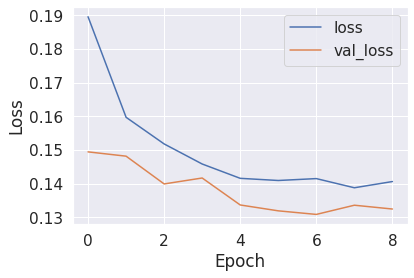

In [49]:
plt.plot(alexNet_model.history.history['loss'])
plt.plot(alexNet_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

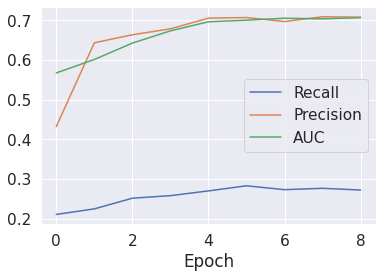

In [50]:
plt.plot(alexNet_model.history.history['Recall'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [51]:
y_pred = alexNet_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [52]:
init_thresholds = np.arange(0,1,0.05)

In [53]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.24489071805916182
0.2956192797155794
0.2654443956178923
0.1821134031864671
0.09591973362186114
0.01114020696640012
-0.0803633716394707
-0.18701509494872195
-0.28088615602692996
-0.3487247614469906
-0.4111340892545097
-0.4628107477579539
-0.5288372627530744
-0.5936628195560526
-0.6585351363103092
-0.7259686785698155
-0.7802842247584588
-0.8127705992571775
-0.8238661257831744


In [54]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.319255
         Iterations: 301
         Function evaluations: 555


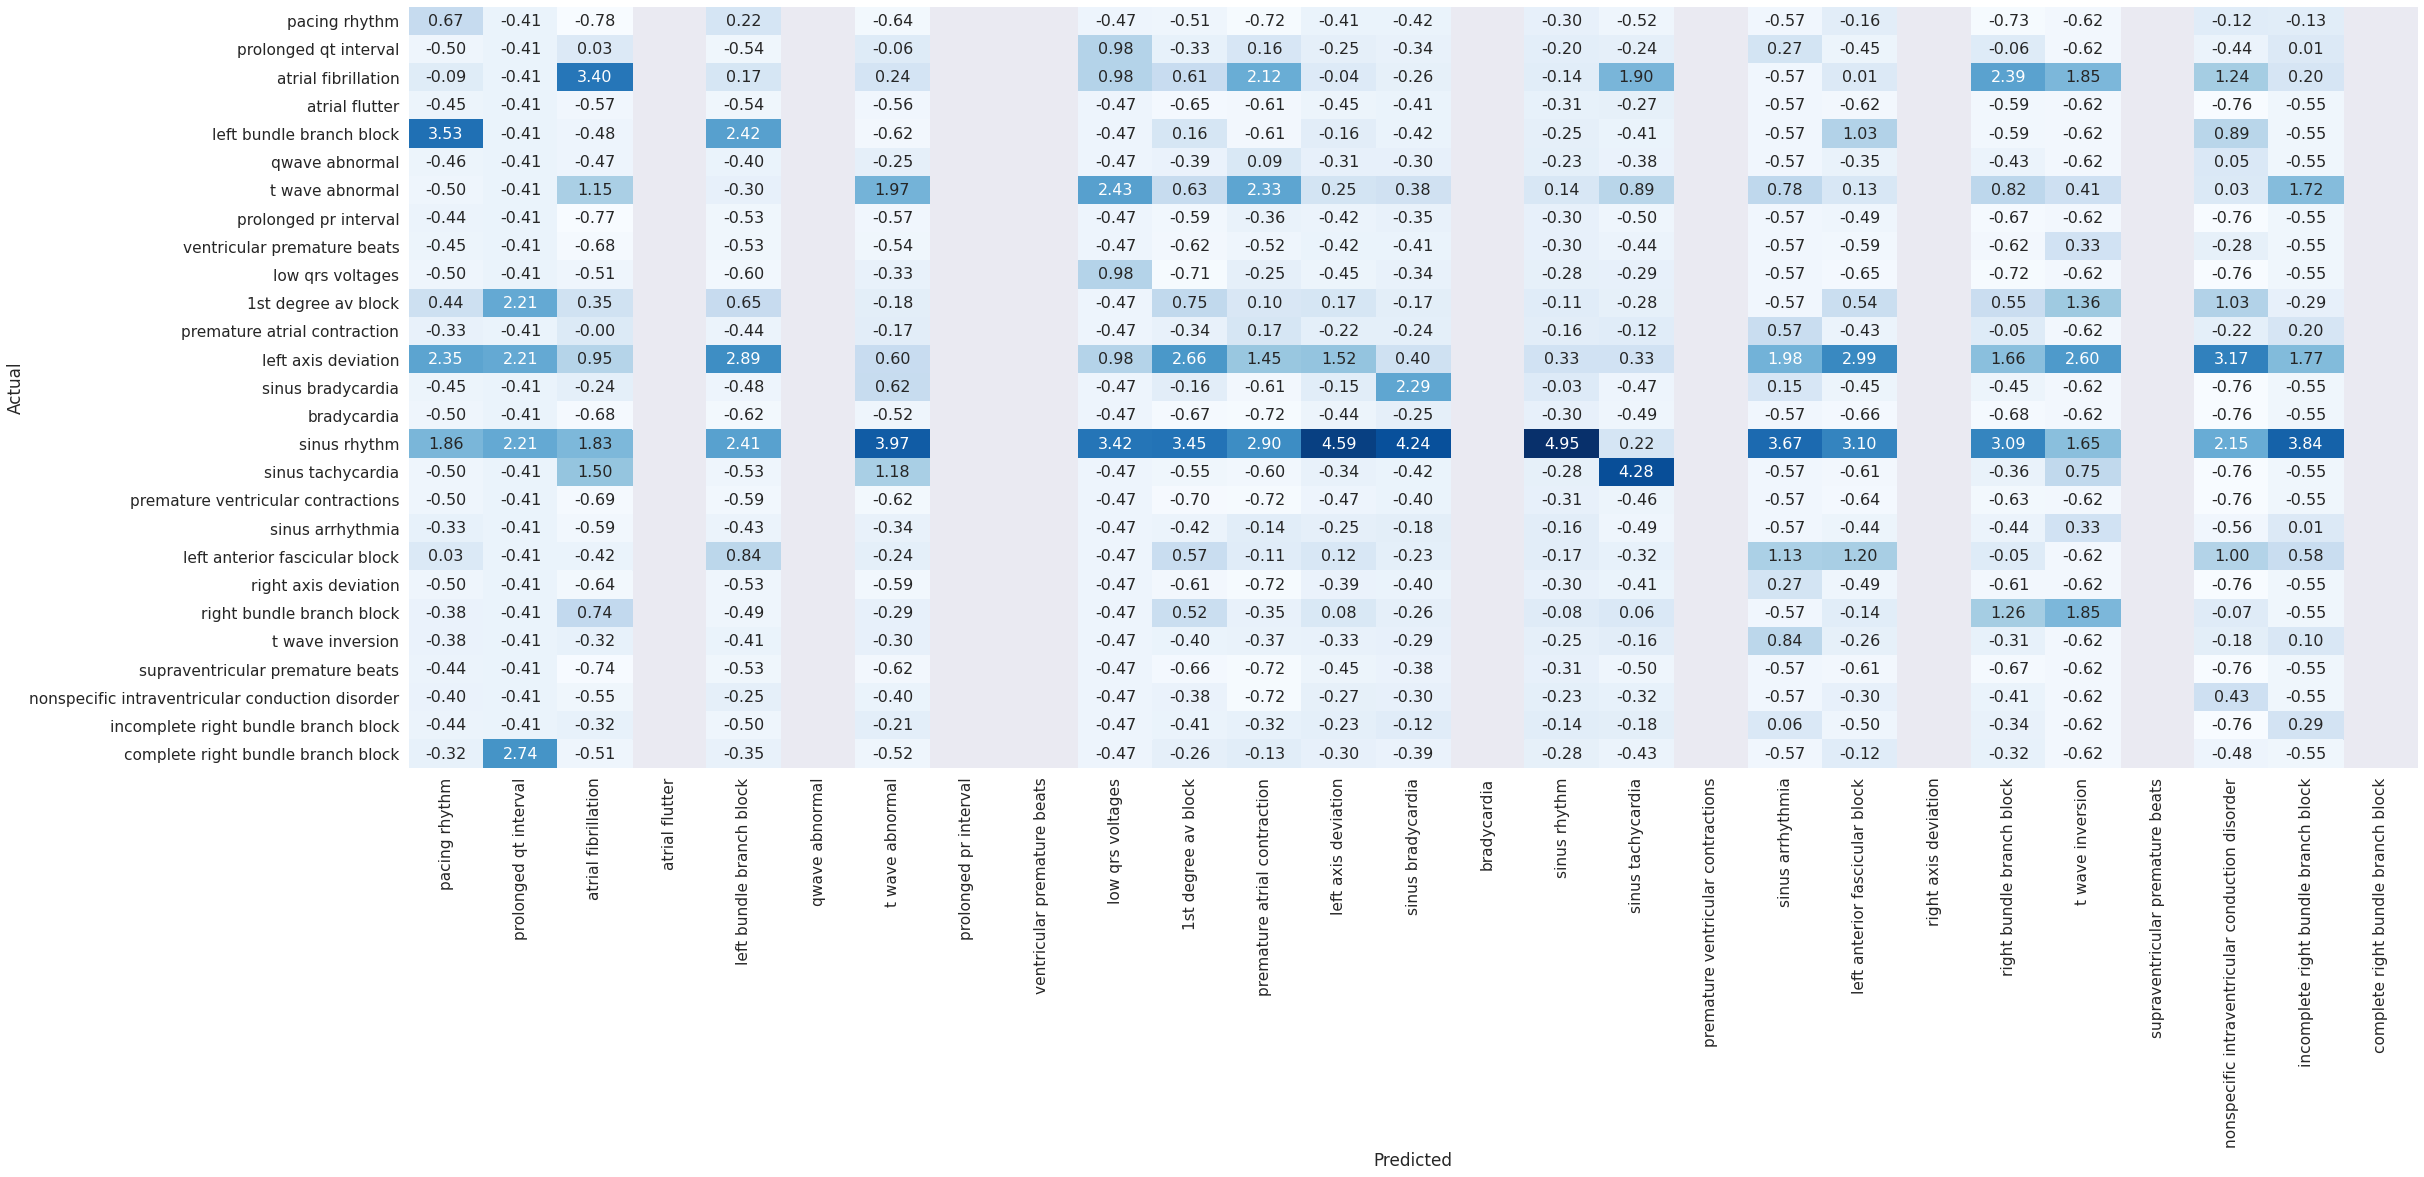

In [55]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_alexnet.png", dpi=100)

# VGG-16

In [56]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same',  input_shape=(5000,12)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(GlobalAveragePooling1D())
vgg_16_model.add(Dense(256, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(128, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(27, activation='sigmoid'))

In [57]:
 vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [58]:
vgg_16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 5000, 64)          2368      
_________________________________________________________________
batch_normalization_7 (Batch (None, 5000, 64)          256       
_________________________________________________________________
activation_7 (Activation)    (None, 5000, 64)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 5000, 64)          12352     
_________________________________________________________________
batch_normalization_8 (Batch (None, 5000, 64)          256       
_________________________________________________________________
activation_8 (Activation)    (None, 5000, 64)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2500, 64)         

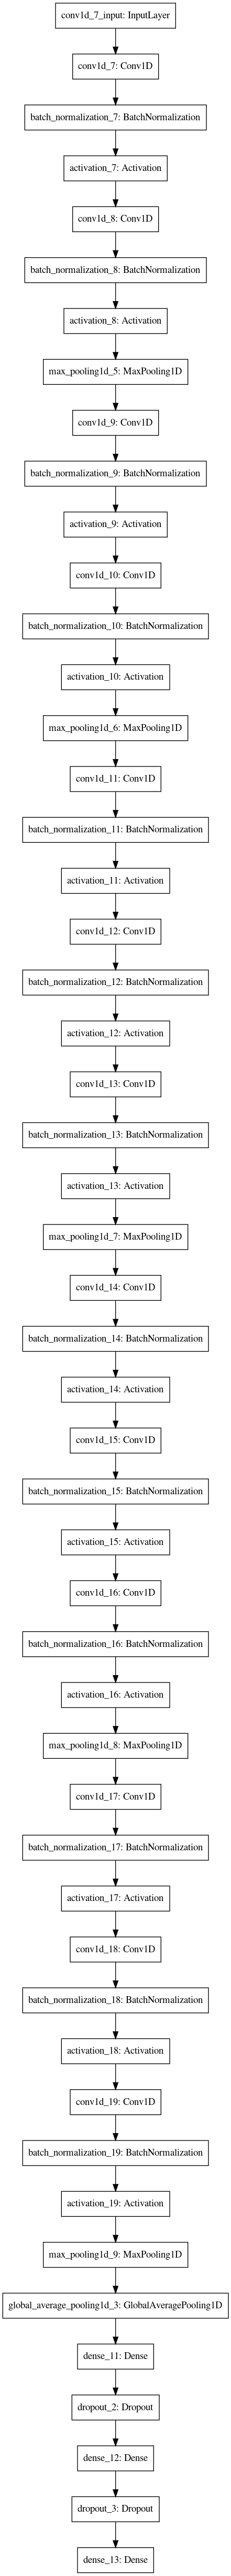

In [59]:
plot_model(vgg_16_model)

In [60]:
batchsize = 10
vgg_16_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
388/387 [==============================] - 28s 73ms/step - loss: 0.1880 - accuracy: 0.9445 - Recall: 0.1955 - Precision: 0.4169 - AUC: 0.5701 - val_loss: 0.1785 - val_accuracy: 0.9514 - val_Recall: 0.3215 - val_Precision: 0.5545 - val_AUC: 0.6542
Epoch 2/10
388/387 [==============================] - 27s 70ms/step - loss: 0.1573 - accuracy: 0.9544 - Recall: 0.2385 - Precision: 0.6674 - AUC: 0.6132 - val_loss: 0.1796 - val_accuracy: 0.9516 - val_Recall: 0.3256 - val_Precision: 0.5580 - val_AUC: 0.6698
Epoch 3/10
388/387 [==============================] - 28s 72ms/step - loss: 0.1536 - accuracy: 0.9548 - Recall: 0.2674 - Precision: 0.6814 - AUC: 0.6506 - val_loss: 0.1689 - val_accuracy: 0.9530 - val_Recall: 0.3296 - val_Precision: 0.5847 - val_AUC: 0.6749
Epoch 4/10
388/387 [==============================] - 27s 71ms/step - loss: 0.1521 - accuracy: 0.9543 - Recall: 0.2579 - Precision: 0.6723 - AUC: 0.6526 - val_loss: 0.1486 - val_accuracy: 0.9545 - val_Recall: 0.2980 - val_Prec

Text(0, 0.5, 'Accuracy')

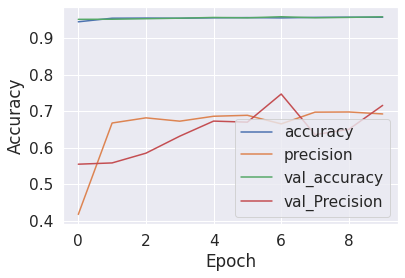

In [61]:
plt.plot(vgg_16_model.history.history['accuracy'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
plt.plot(vgg_16_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

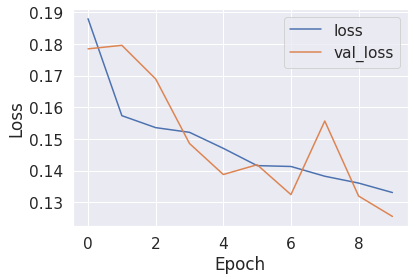

In [62]:
plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

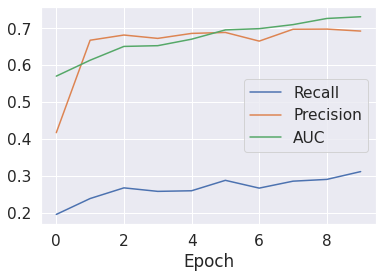

In [63]:
plt.plot(vgg_16_model.history.history['Recall'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [64]:
y_pred = vgg_16_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [65]:
init_thresholds = np.arange(0,1,0.05)

In [66]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.26363940475210923
0.2817116660463774
0.321376378139685
0.2782308355588562
0.22359039193482555
0.16527768893709804
0.10525852072611393
0.033208185503152216
-0.05077641617188343
-0.12401497693938465
-0.2003929253227645
-0.2640528175316083
-0.3316734809178829
-0.40988750961425013
-0.5034425431260909
-0.6024553168295118
-0.7110782770413588
-0.7996883847142496
-0.8238661257831744


In [67]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.327739
         Iterations: 189
         Function evaluations: 443


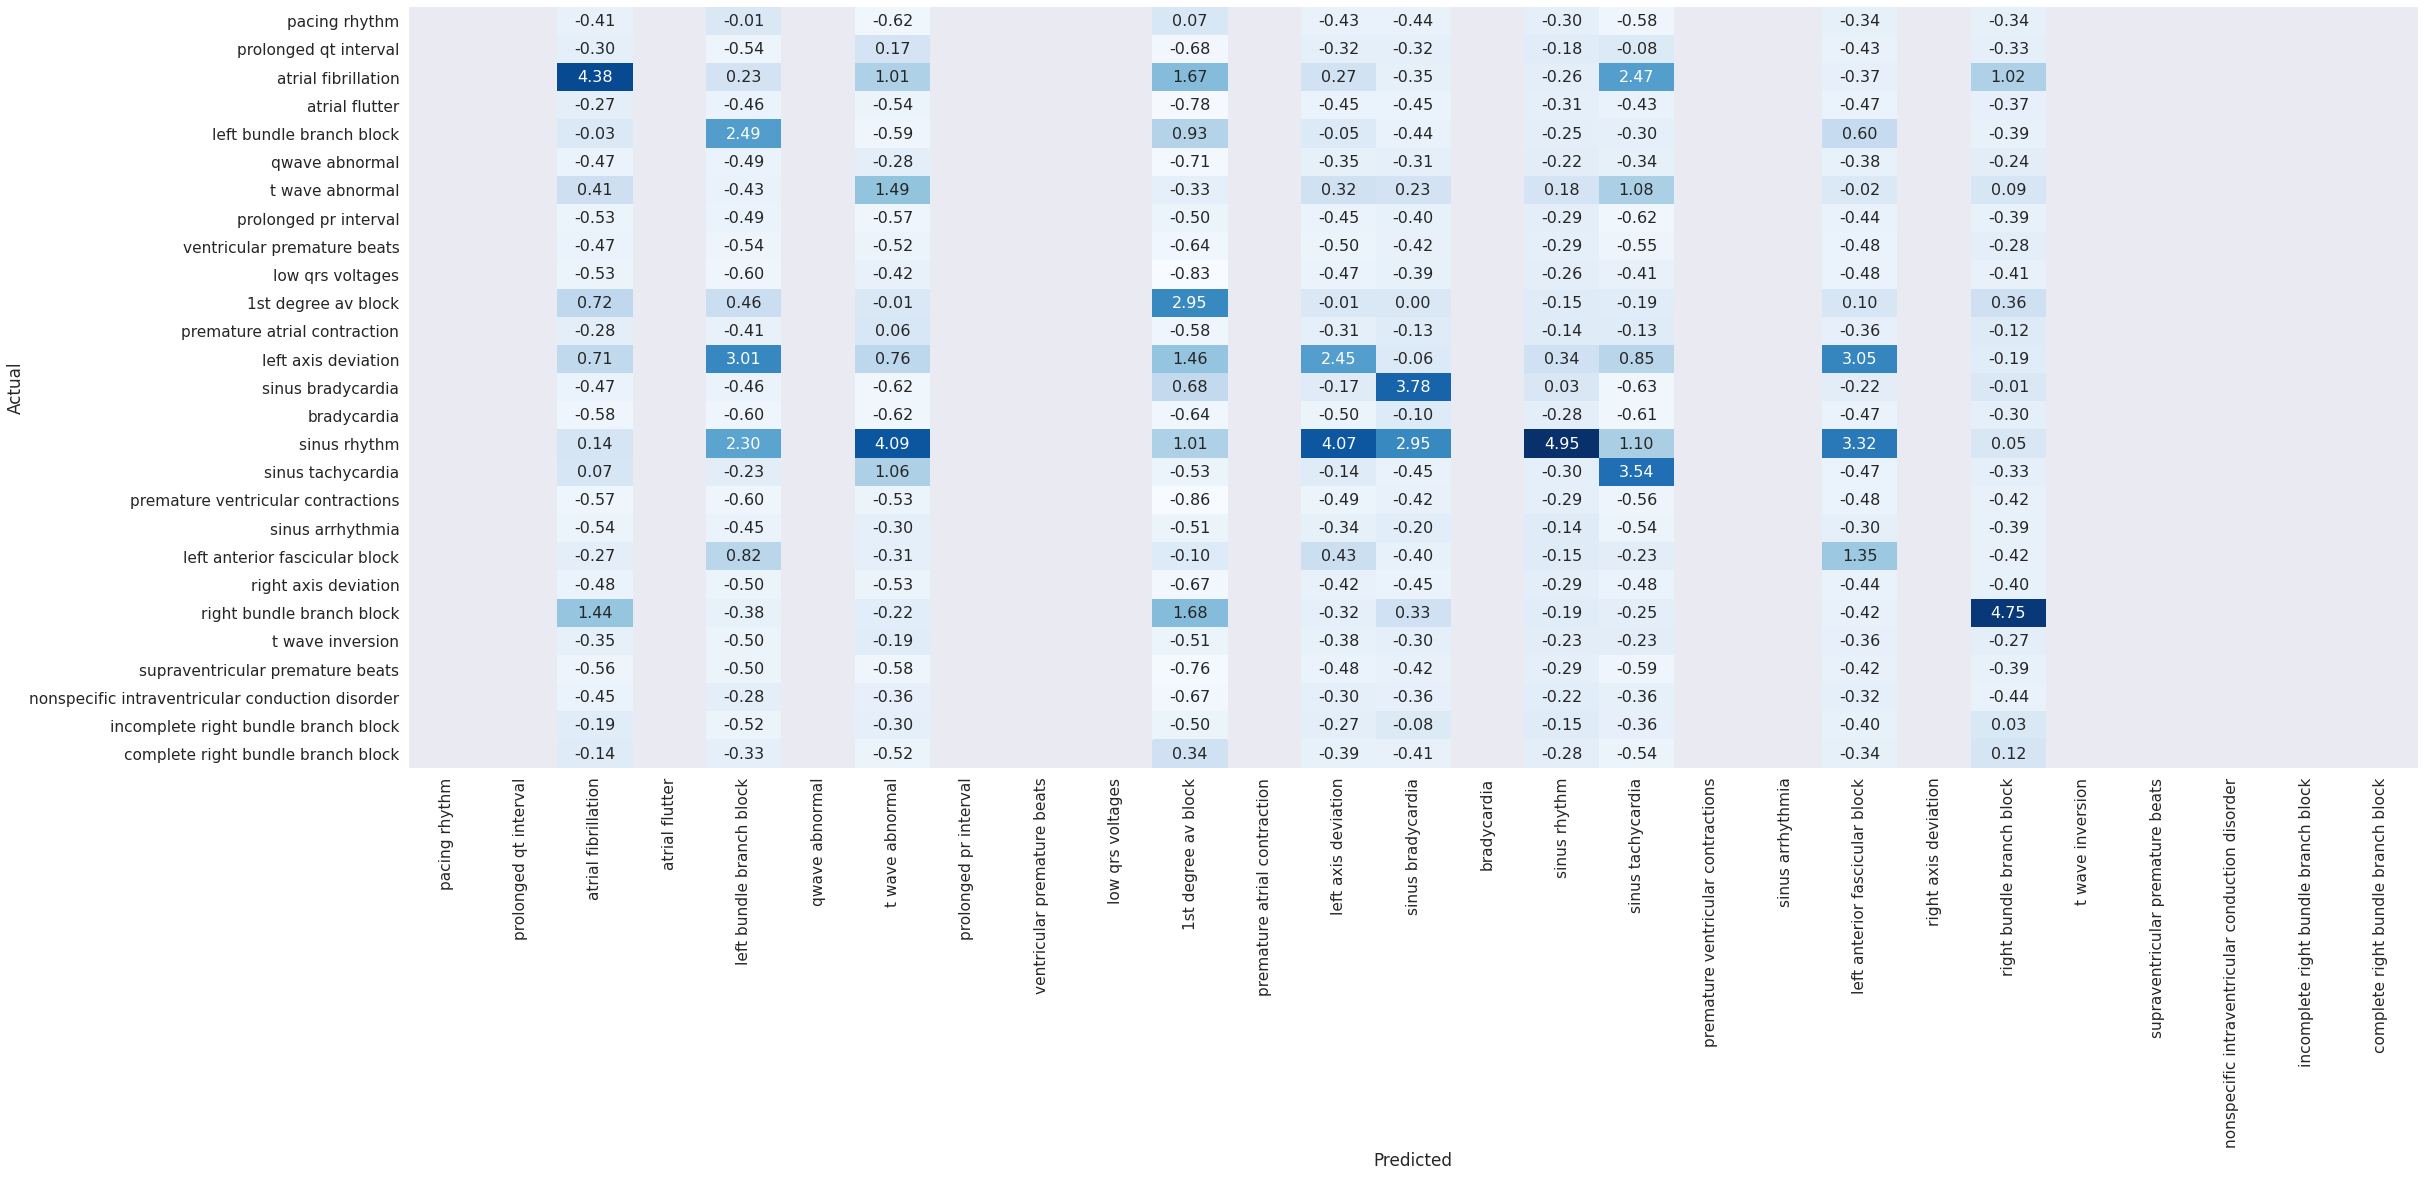

In [68]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_vgg16.png", dpi=100)

# ResNet50

In [69]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(27,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [70]:
resNet50_model = ResNet50(input_shape = (5000,12))

In [71]:
 resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [72]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 5006, 12)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 2500, 64)     5440        zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 2500, 64)     256         conv1d_20[0][0]                  
___________________________________________________________________________________________

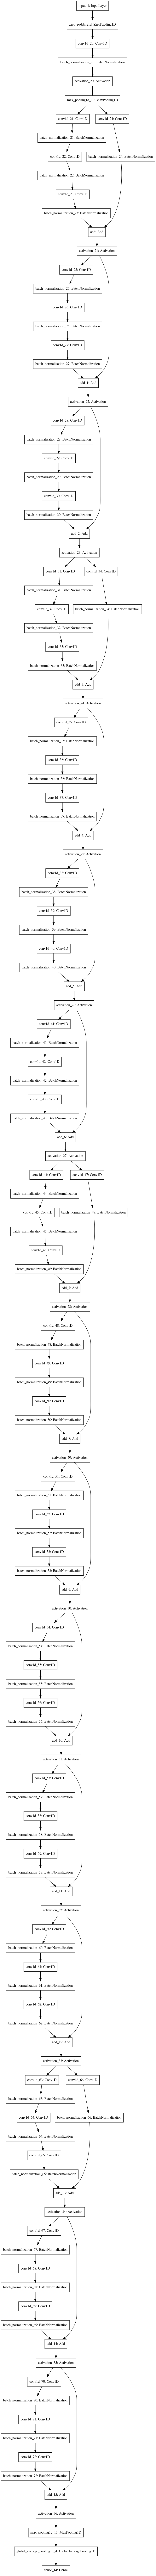

In [73]:
plot_model(resNet50_model)

In [74]:
batchsize = 10
resNet50_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
388/387 [==============================] - 58s 151ms/step - loss: 0.1916 - accuracy: 0.9462 - Recall: 0.2068 - Precision: 0.4674 - AUC: 0.5539 - val_loss: 0.3358 - val_accuracy: 0.9475 - val_Recall: 0.0045 - val_Precision: 0.2143 - val_AUC: 0.5458
Epoch 2/10
388/387 [==============================] - 55s 142ms/step - loss: 0.1607 - accuracy: 0.9524 - Recall: 0.2478 - Precision: 0.6102 - AUC: 0.6439 - val_loss: 0.2845 - val_accuracy: 0.9531 - val_Recall: 0.2644 - val_Precision: 0.6116 - val_AUC: 0.5807
Epoch 3/10
388/387 [==============================] - 63s 163ms/step - loss: 0.1546 - accuracy: 0.9525 - Recall: 0.2451 - Precision: 0.5989 - AUC: 0.6536 - val_loss: 0.3688 - val_accuracy: 0.9420 - val_Recall: 0.4138 - val_Precision: 0.4381 - val_AUC: 0.5791
Epoch 4/10
388/387 [==============================] - 55s 141ms/step - loss: 0.1467 - accuracy: 0.9545 - Recall: 0.2715 - Precision: 0.6322 - AUC: 0.6778 - val_loss: 0.4938 - val_accuracy: 0.9329 - val_Recall: 0.0314 - val_

Text(0, 0.5, 'Accuracy')

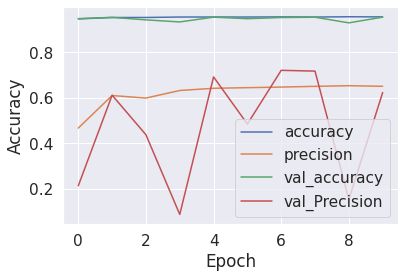

In [75]:
plt.plot(resNet50_model.history.history['accuracy'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_accuracy'])
plt.plot(resNet50_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

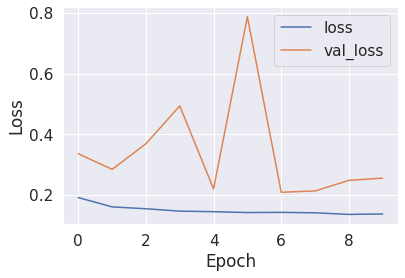

In [76]:
plt.plot(resNet50_model.history.history['loss'])
plt.plot(resNet50_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

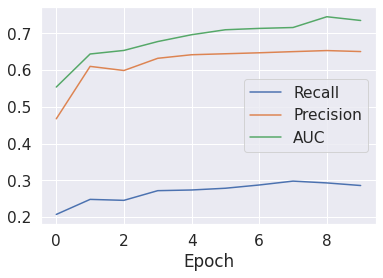

In [77]:
plt.plot(resNet50_model.history.history['Recall'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [78]:
y_pred = resNet50_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [79]:
init_thresholds = np.arange(0,1,0.05)

In [80]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.15339646387200373
0.16340025656285193
0.13065140480718387
0.08284240418688545
0.02712326947809927
-0.023899040141924573
-0.062484143729563936
-0.09688172813255407
-0.13196128754670058
-0.1642571370265447
-0.19990611066478253
-0.2413004591862048
-0.27956465590821233
-0.3232063283489098
-0.37484500963974987
-0.44597320377136107
-0.5251497555691774
-0.6166200271488835
-0.7135039625834861
-0.799349215328516


In [81]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.172698
         Iterations: 280
         Function evaluations: 530


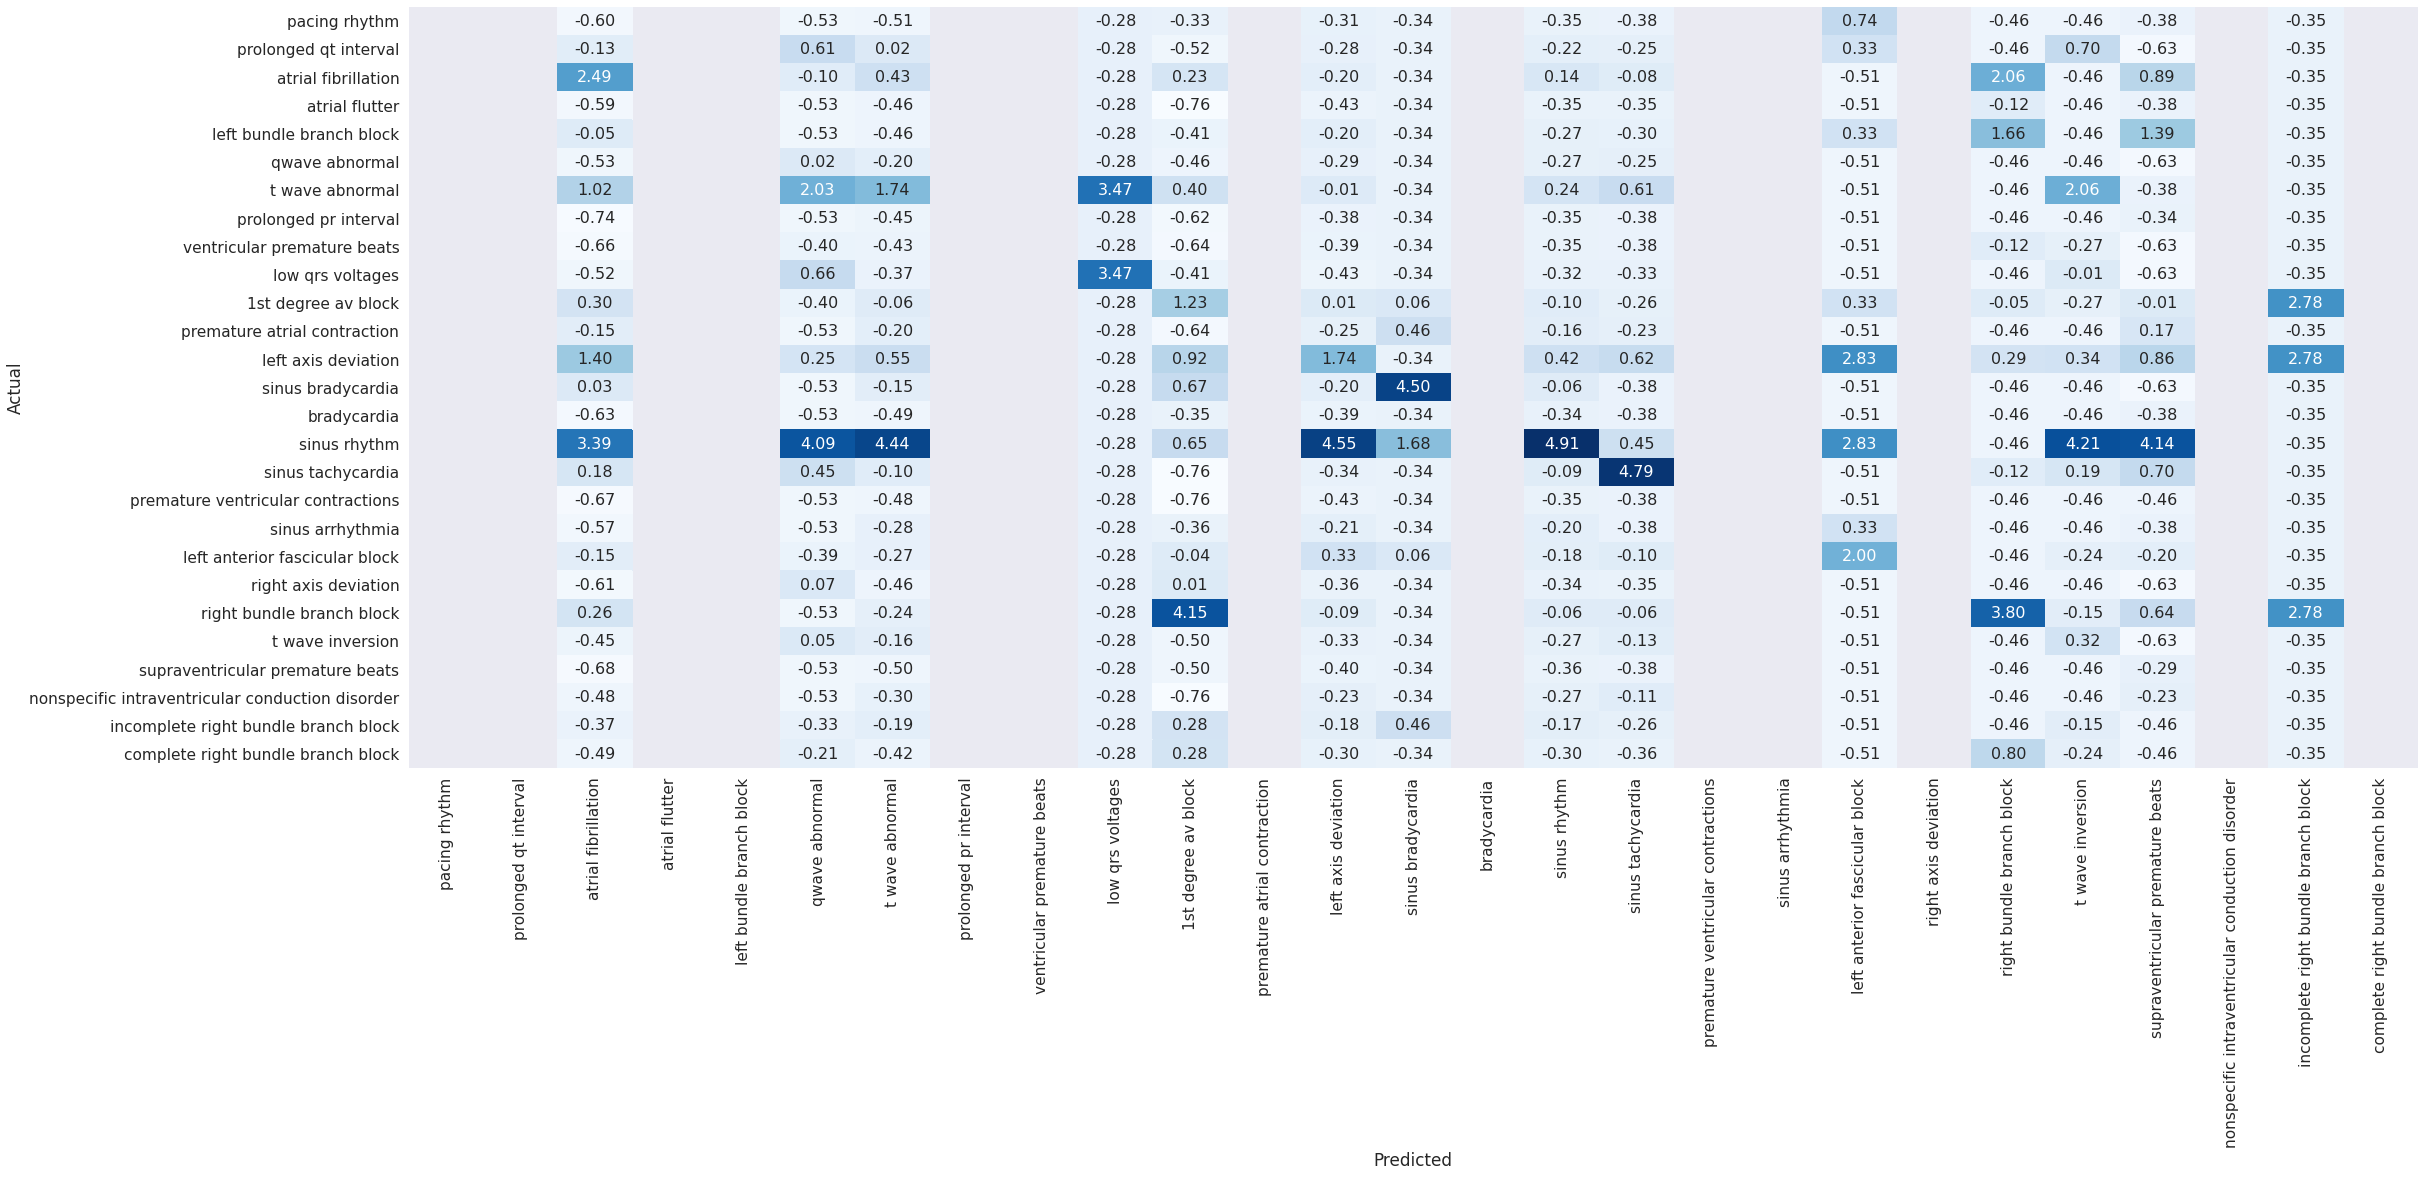

In [82]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_resnet50.png", dpi=100)

# Inception

In [83]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(27,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [84]:
inception_model = inception_model(input_shape = (5000,12))

In [85]:
 inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [86]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 5006, 12)     0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_73 (Conv1D)              (None, 5006, 64)     5440        zero_padding1d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 5006, 64)     256         conv1d_73[0][0]                  
__________________________________________________________________________________________

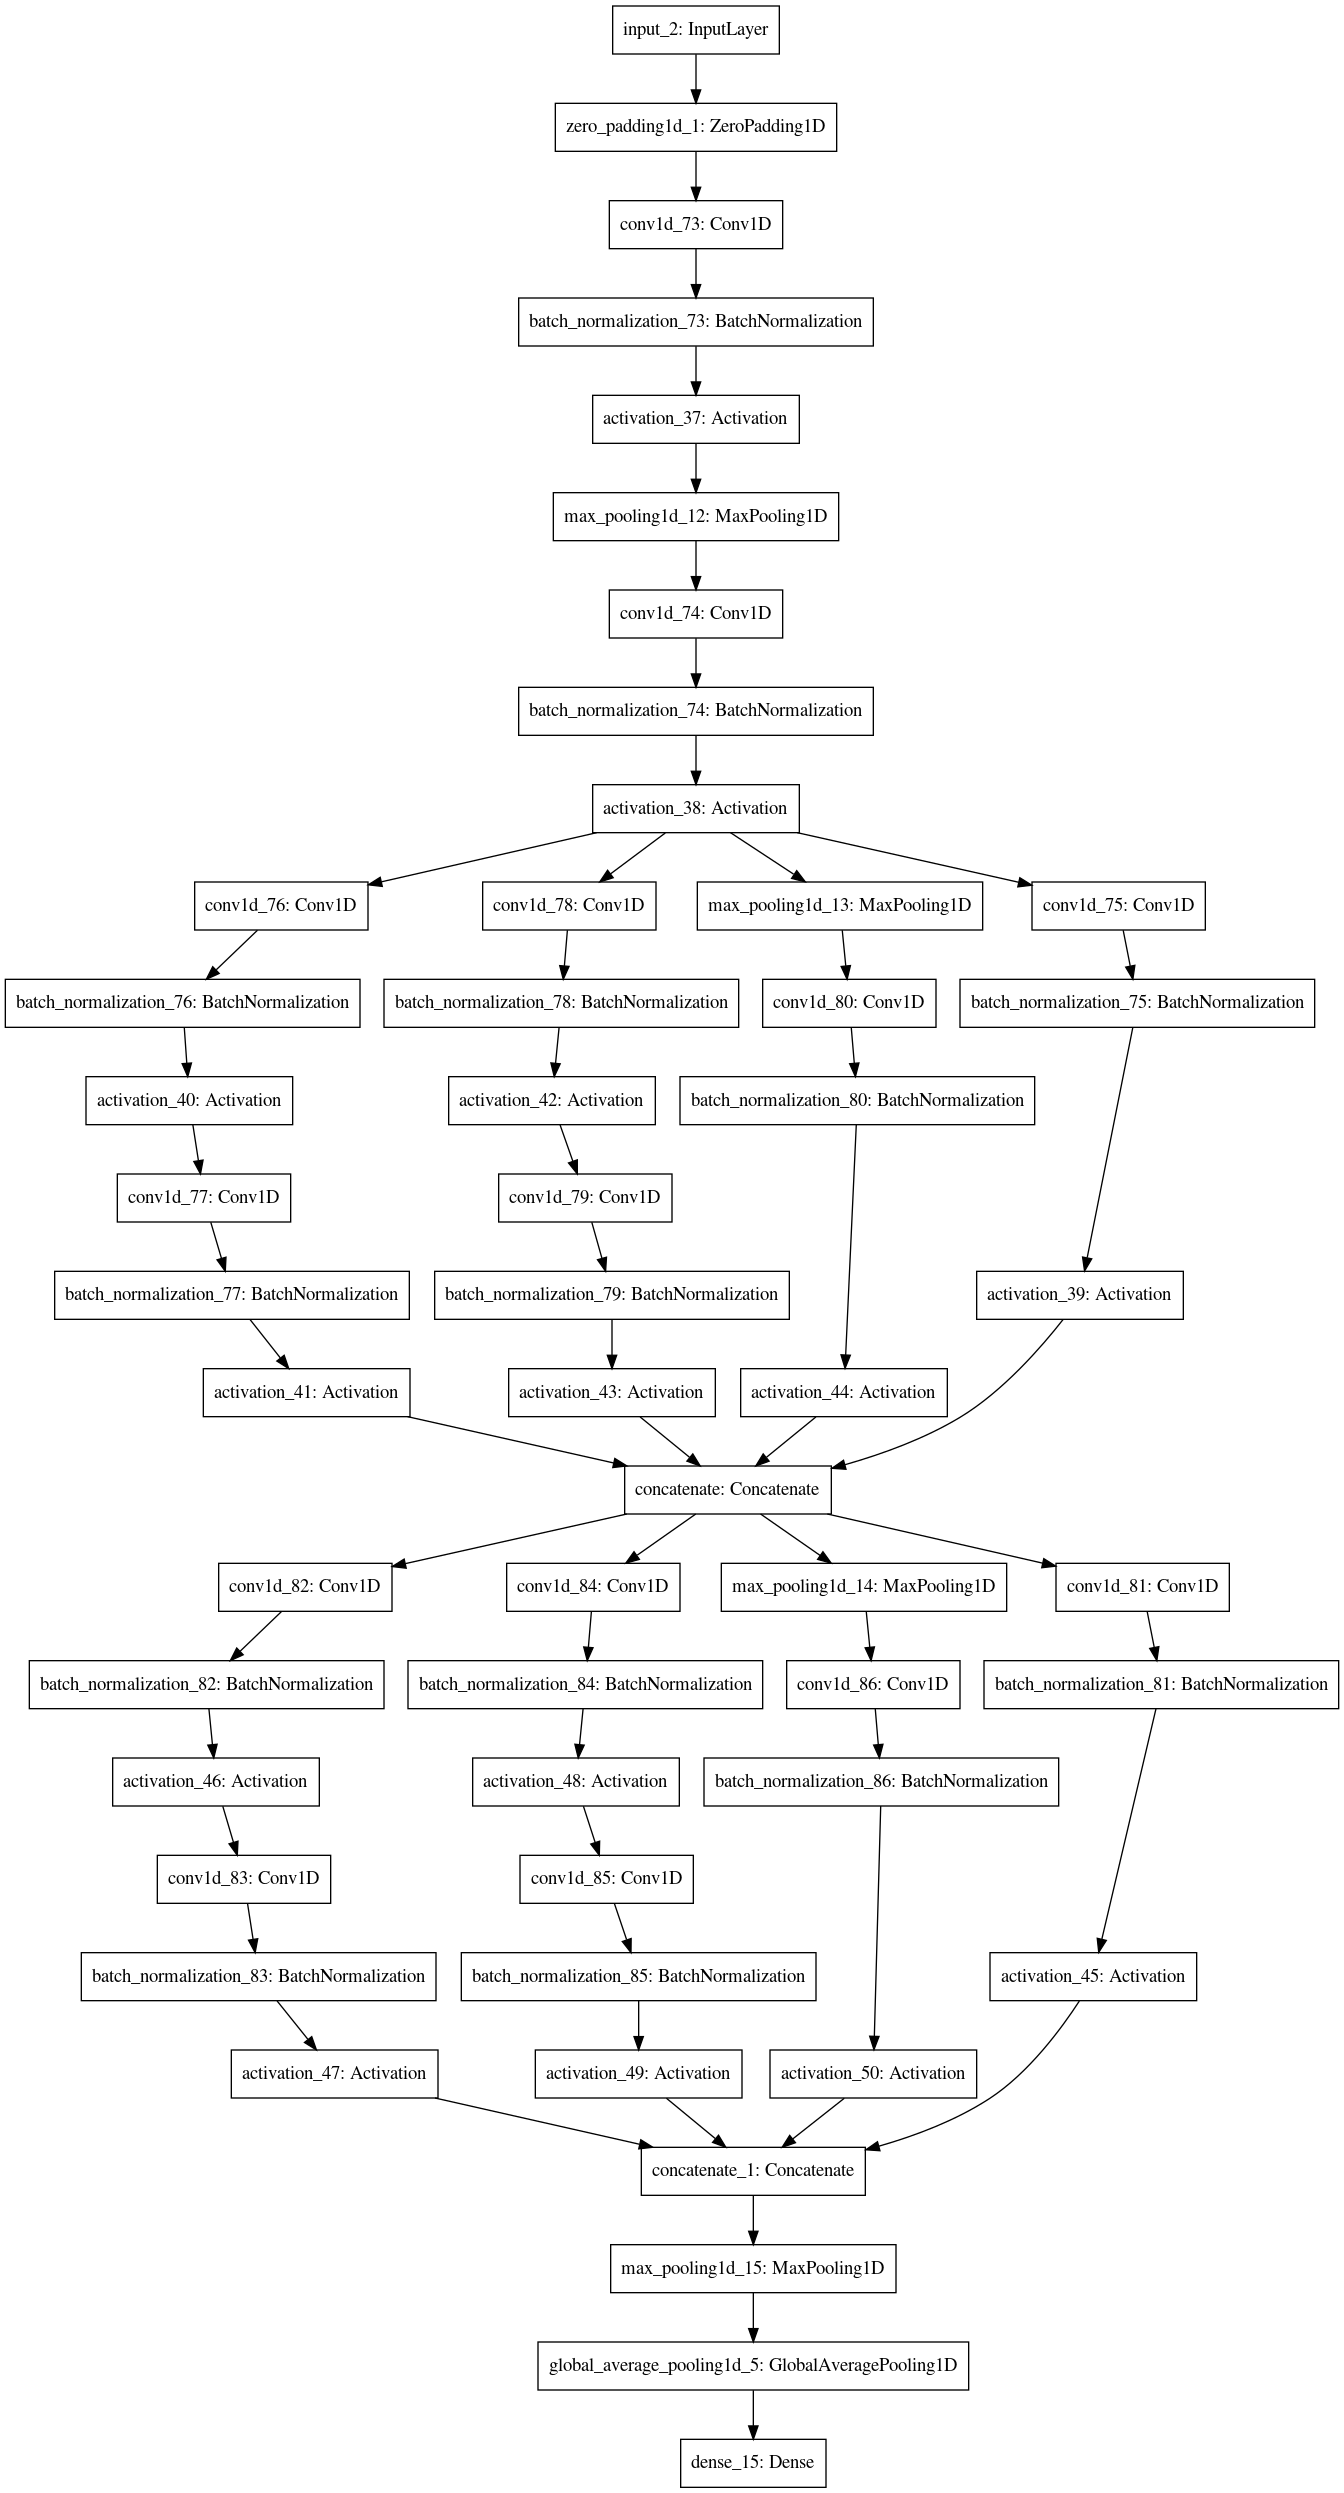

In [87]:
plot_model(inception_model)

In [88]:
batchsize = 10
inception_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
388/387 [==============================] - 34s 87ms/step - loss: 0.1887 - accuracy: 0.9380 - Recall: 0.2393 - Precision: 0.3491 - AUC: 0.5832 - val_loss: 0.1443 - val_accuracy: 0.9549 - val_Recall: 0.2914 - val_Precision: 0.6446 - val_AUC: 0.7164
Epoch 2/10
388/387 [==============================] - 33s 85ms/step - loss: 0.1442 - accuracy: 0.9544 - Recall: 0.2412 - Precision: 0.6851 - AUC: 0.7018 - val_loss: 0.1369 - val_accuracy: 0.9561 - val_Recall: 0.2488 - val_Precision: 0.7255 - val_AUC: 0.7471
Epoch 3/10
388/387 [==============================] - 33s 85ms/step - loss: 0.1340 - accuracy: 0.9561 - Recall: 0.2691 - Precision: 0.6929 - AUC: 0.7199 - val_loss: 0.1352 - val_accuracy: 0.9532 - val_Recall: 0.1764 - val_Precision: 0.6922 - val_AUC: 0.7586
Epoch 4/10
388/387 [==============================] - 33s 85ms/step - loss: 0.1301 - accuracy: 0.9564 - Recall: 0.2795 - Precision: 0.6989 - AUC: 0.7434 - val_loss: 0.1294 - val_accuracy: 0.9559 - val_Recall: 0.2086 - val_Prec

Text(0, 0.5, 'Accuracy')

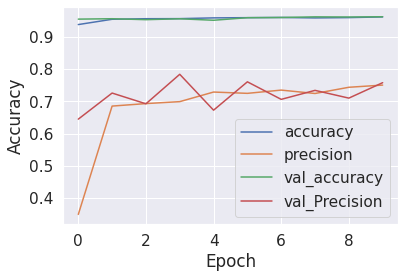

In [89]:
plt.plot(inception_model.history.history['accuracy'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

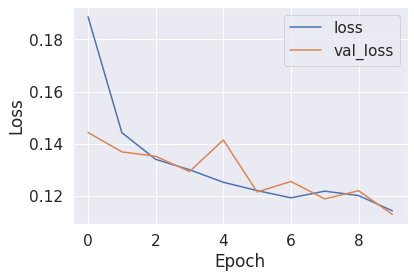

In [90]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

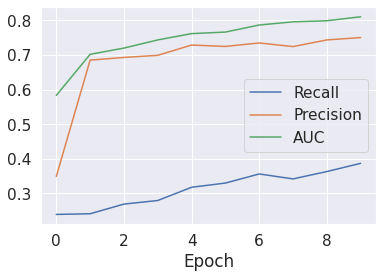

In [91]:
plt.plot(inception_model.history.history['Recall'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [92]:
y_pred = resNet50_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [93]:
init_thresholds = np.arange(0,1,0.05)

In [94]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.15339646387200373
0.16340025656285193
0.13065140480718387
0.08284240418688545
0.02712326947809927
-0.023899040141924573
-0.062484143729563936
-0.09688172813255407
-0.13196128754670058
-0.1642571370265447
-0.19990611066478253
-0.2413004591862048
-0.27956465590821233
-0.3232063283489098
-0.37484500963974987
-0.44597320377136107
-0.5251497555691774
-0.6166200271488835
-0.7135039625834861
-0.799349215328516


In [95]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.172698
         Iterations: 280
         Function evaluations: 530


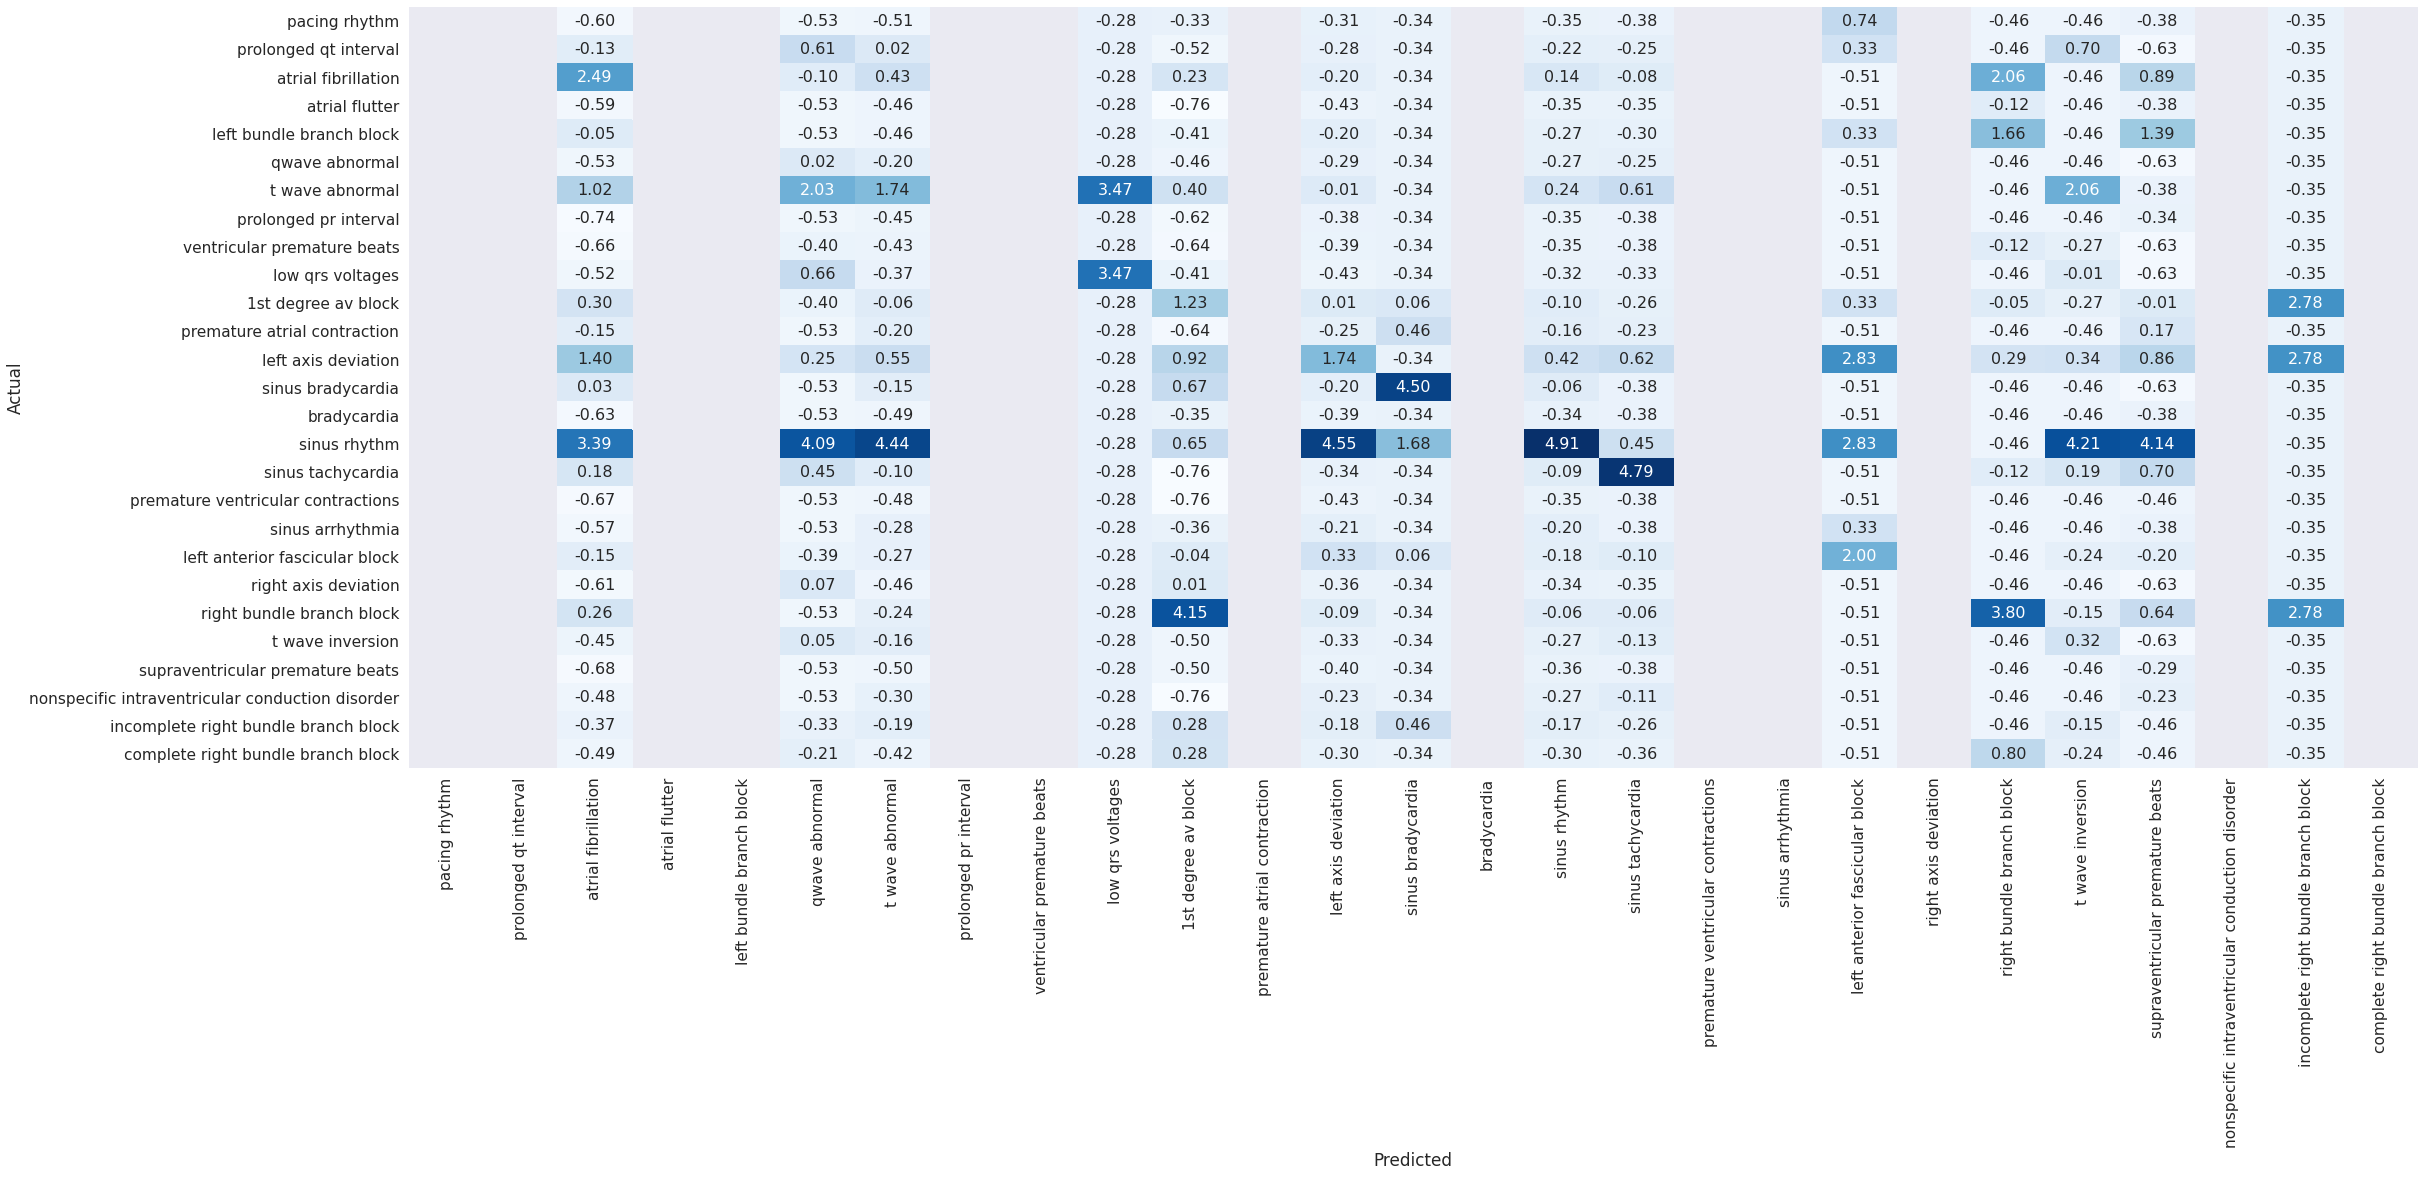

In [96]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_inception.png", dpi=100)

# RNN

# LSTM

In [97]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(5000,12), return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(27, activation = 'sigmoid'))

In [98]:
 lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [99]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5000, 64)          19712     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 27)                891       
Total params: 55,707
Trainable params: 55,707
Non-trainable params: 0
_________________________________________________________________


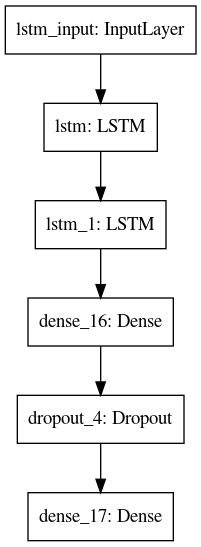

In [100]:
plot_model(lstm_model)

In [101]:
batchsize = 10
lstm_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
388/387 [==============================] - 132s 339ms/step - loss: 0.2160 - accuracy: 0.9298 - Recall: 0.1847 - Precision: 0.2618 - AUC: 0.5024 - val_loss: 0.1589 - val_accuracy: 0.9510 - val_Recall: 0.1080 - val_Precision: 0.6753 - val_AUC: 0.5423
Epoch 2/10
388/387 [==============================] - 132s 339ms/step - loss: 0.1684 - accuracy: 0.9509 - Recall: 0.1925 - Precision: 0.5804 - AUC: 0.5277 - val_loss: 0.1575 - val_accuracy: 0.9504 - val_Recall: 0.0751 - val_Precision: 0.7161 - val_AUC: 0.5573
Epoch 3/10
388/387 [==============================] - 132s 339ms/step - loss: 0.1664 - accuracy: 0.9518 - Recall: 0.2088 - Precision: 0.6186 - AUC: 0.5229 - val_loss: 0.1554 - val_accuracy: 0.9541 - val_Recall: 0.1904 - val_Precision: 0.7180 - val_AUC: 0.5655
Epoch 4/10
388/387 [==============================] - 132s 340ms/step - loss: 0.1605 - accuracy: 0.9538 - Recall: 0.2401 - Precision: 0.6330 - AUC: 0.5349 - val_loss: 0.1529 - val_accuracy: 0.9556 - val_Recall: 0.2929 - 

Text(0, 0.5, 'Accuracy')

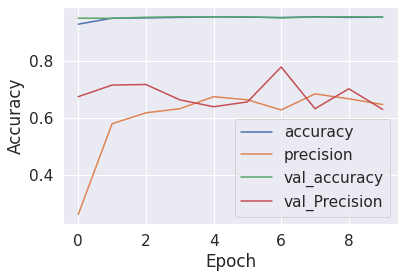

In [102]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

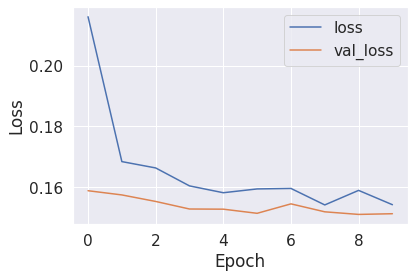

In [103]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

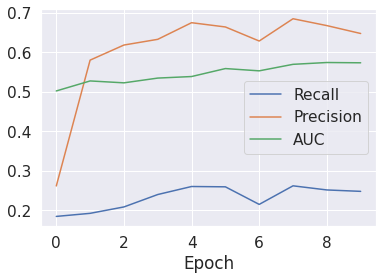

In [104]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [105]:
y_pred = lstm_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [106]:
init_thresholds = np.arange(0,1,0.05)

In [107]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.15076677134784935
0.12629642884629635
0.05688661161408158
-0.010607259695614317
-0.04801072479272047
-0.06227950359496259
-0.07854668073236924
-0.09323833213747841
-0.11197581717051827
-0.13364893260565375
-0.1578570066516686
-0.19306708732112327
-0.25176496452621455
-0.3866934468942966
-0.7052795551528895
-0.7944423247890661
-0.8158868450536904
-0.8238661257831744
-0.8238661257831744


In [108]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.153481
         Iterations: 3
         Function evaluations: 86


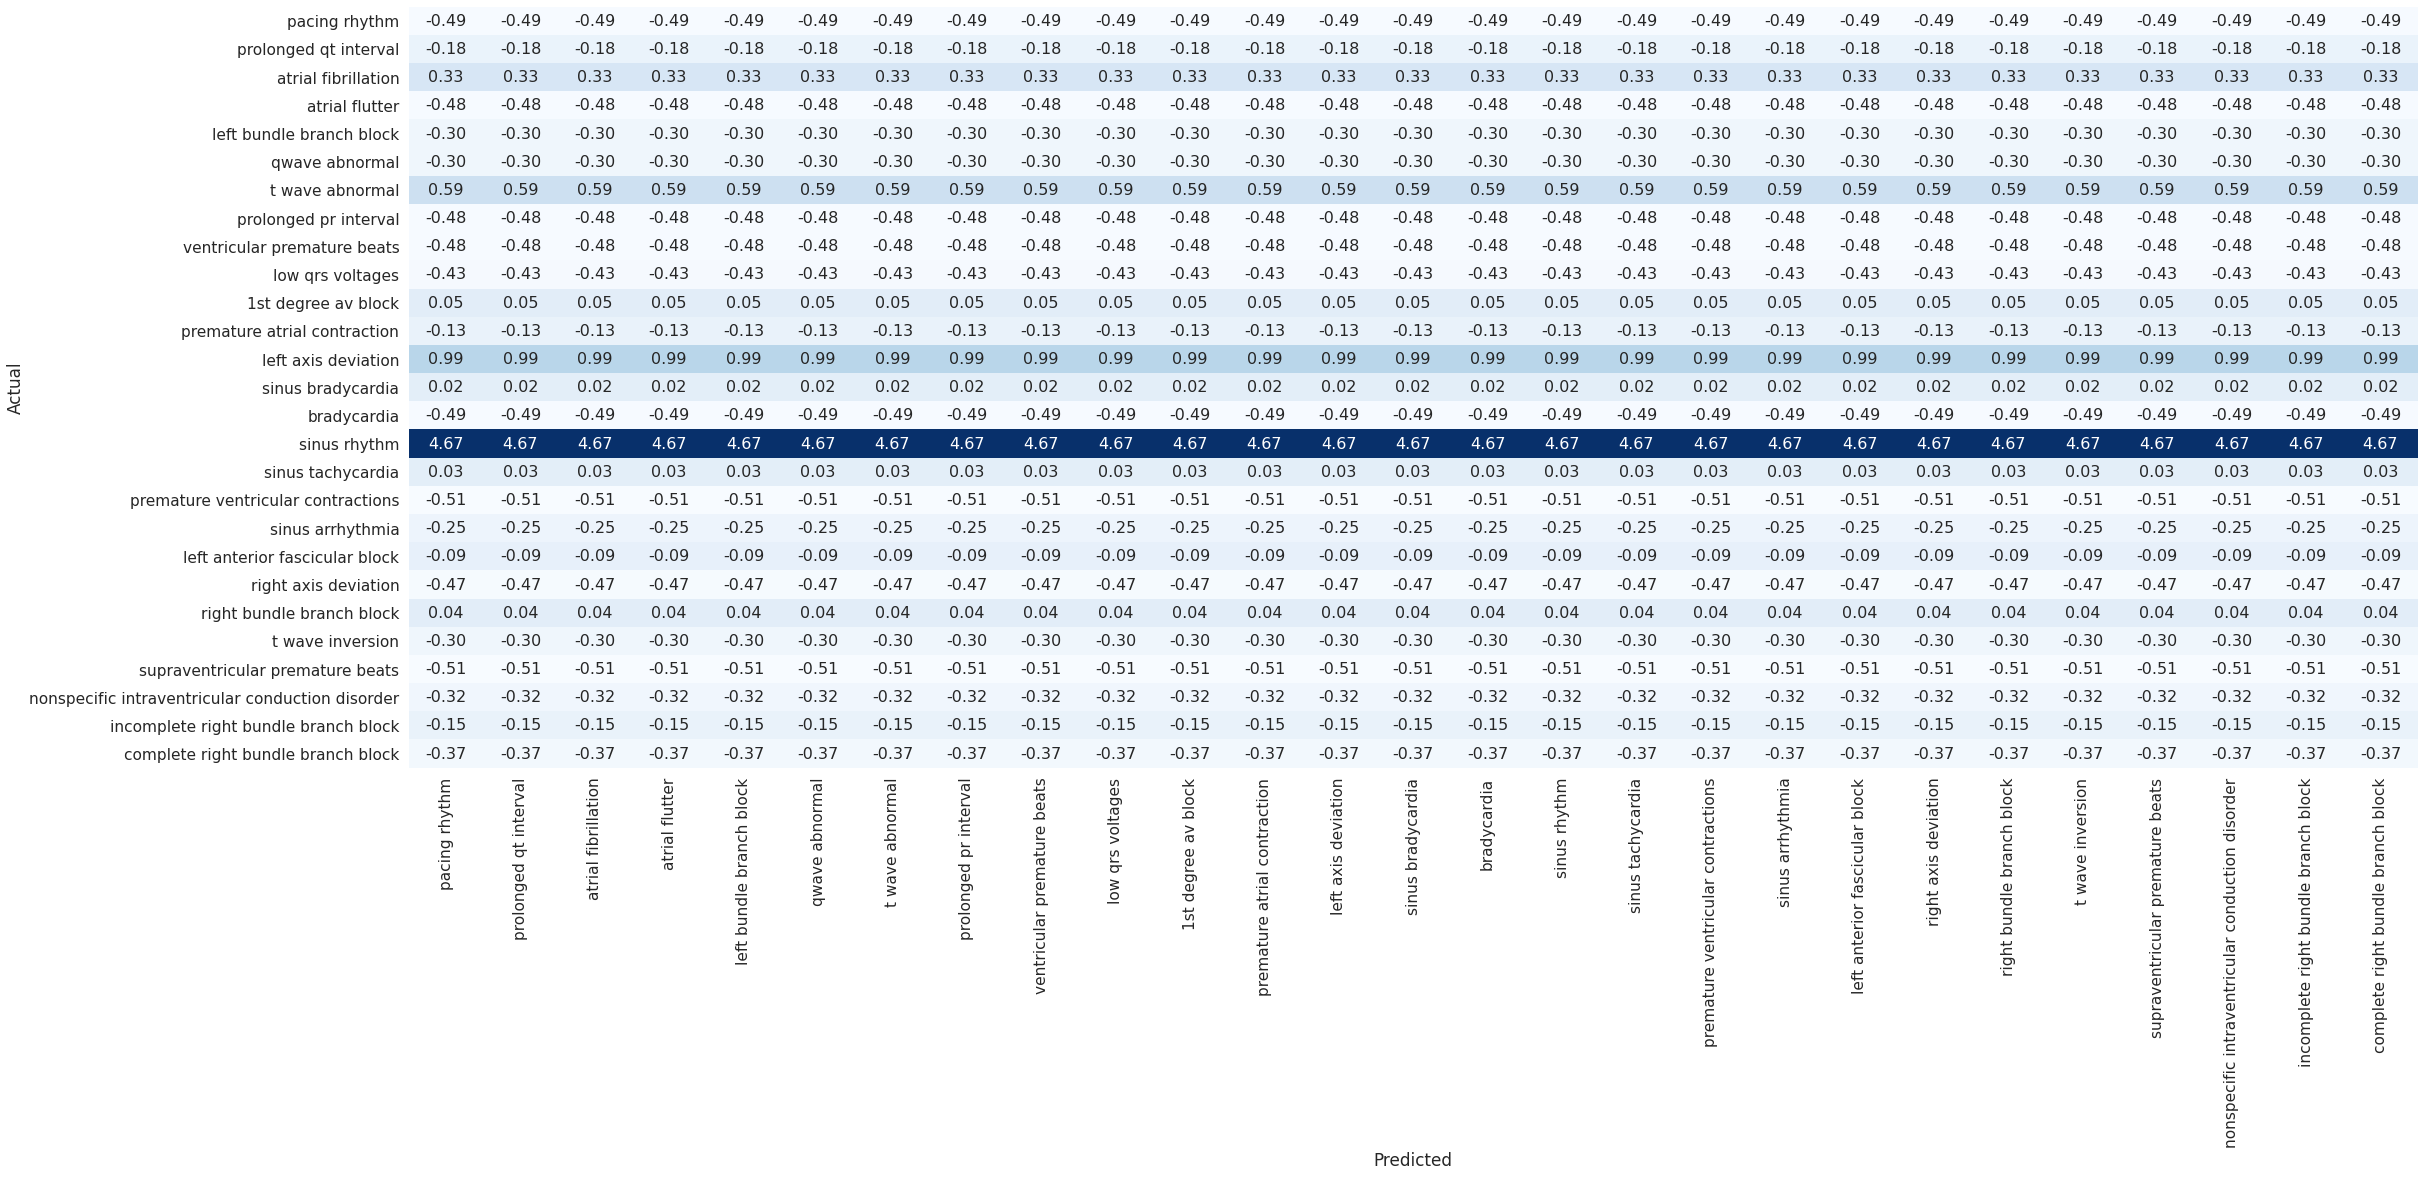

In [109]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_lstm.png", dpi=100)